# Causal Abstraction Analysis with Distributed Alignment Search 

In [1]:
__author__ = "Atticus Geiger"

## Contents

1. [The hierarchical equality task](#The-hierarchical-equality-task)
    1. [An Algorithm that Solves the Equality Task](#An-Algorithm-that-Solves-the-Equality-Task)
        1. [The algorithm with no intervention](#The-algorithm-with-no-intervention)
        1. [The algorithm with an intervention](#The-algorithm-with-an-intervention)
        1. [The algorithm with an interchange intervention](#The-algorithm-with-an-interchange-intervention)
    1. [Hand Crafting an MLP to Solve Hierarchical Equality](#Hand-Crafting-an-MLP-to-Solve-Hierarchical-Equality)        
    1. [Training an MLP to Solve Hierarchical Equality](#Training-an-MLP-to-Solve-Hierarchical-Equality)
1. [Causal abstraction Analysis](#Causal-abstraction)
    1. [Basic intervention: zeroing out part of a hidden layer](#Basic-intervention:-zeroing-out-part-of-a-hidden-layer)
    1. [An interchange intervention](#An-interchange-intervention)
    1. [Alignment](#Alignment)
    1. [Evaluating an Alignment](#Evaluation)
1. [Distributed Alignment Search (DAS)](#Distributed-Alignment-Search)

## Set-up

This notebook is a hands-on introduction to __causal abstraction analysis__ [Geiger*, Lu*, Icard, and Potts (2020)](https://arxiv.org/pdf/2106.02997.pdf) using __distributed alignment search__ [Geiger*, Wu*, Potts, Icard, and Goodman (2020)](https://arxiv.org/pdf/2303.02536.pdf).

In causal abstraction analysis, we assess whether trained models conform to high-level causal models that we specify, not just in terms of their input–output behavior, but also in terms of their internal dynamics. The core technique is the __interchange intervention__, in which a causal model is provided an input and then intermediate variables are fixed to take on the values they would have for a second input.

To motivate and illustrate these concepts, we're going to focus on a hierarchical equality task, building on work by [Geiger, Carstensen, Frank, and Potts (2020)](https://arxiv.org/abs/2006.07968).

In [1]:
import pyvene

In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
import random
import copy
import itertools
import numpy as np
from tqdm import tqdm, trange

from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup

from pyvene.models.mlp.modelings_mlp import MLPConfig
from pyvene import create_mlp_classifier
from pyvene import (
    VanillaIntervention,
    RotatedSpaceIntervention,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)

In [3]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

### Intervenable Model

In [4]:
import json, logging, torch, types
import nnsight
import numpy as np
from collections import OrderedDict
from typing import List, Optional, Tuple, Union, Dict, Any

from pyvene.models.constants import *
from pyvene.models.basic_utils import *
from pyvene.models.modeling_utils import *
from pyvene.models.intervention_utils import *
from pyvene.models.interventions import *
from pyvene.models.configuration_intervenable_model import (
    IntervenableConfig,
    RepresentationConfig,
)
from pyvene.models.interventions import (
    TrainableIntervention,
    SkipIntervention,
    CollectIntervention,
    BoundlessRotatedSpaceIntervention
)

from torch import optim
from transformers import get_linear_schedule_with_warmup
from dataclasses import dataclass
from transformers.utils import ModelOutput
from tqdm import tqdm, trange

@dataclass
class IntervenableModelOutput(ModelOutput):
    """
    Output of the IntervenableModel, including original outputs, intervened outputs, and collected activations.
    """
    original_outputs: Optional[Any] = None
    intervened_outputs: Optional[Any] = None
    collected_activations: Optional[Any] = None


class BaseModel(nn.Module):
    """
    Base model class for sharing static vars and methods.
    """

    def __init__(self, config, model, backend, **kwargs):
        super().__init__()
        
        super().__init__()
        if isinstance(config, dict) or isinstance(config, list):
            config = IntervenableConfig(
                representations = config
            )
        self.config = config
        
        self.mode = config.mode
        intervention_type = config.intervention_types
        self.is_model_stateless = is_stateless(model)
        self.config.model_type = str(type(model)) # backfill
        self.use_fast = kwargs["use_fast"] if "use_fast" in kwargs else False

        self.model_has_grad = False
        if self.use_fast:
            logging.warn(
                "Detected use_fast=True means the intervention location "
                "will be static within a batch.\n\nIn case multiple "
                "location tags are passed only the first one will "
                "be considered"
            )
        # each representation can get a different intervention type
        if type(intervention_type) == list:
            assert len(intervention_type) == len(
                config.representations
            )

        ###
        # We instantiate intervention_layers at locations.
        # Note that the layer name mentioned in the config is
        # abstract. Not the actual module name of the model.
        #
        # This script will automatically convert abstract
        # name into module name if the model type is supported.
        #
        # To support a new model type, you need to provide a
        # mapping between supported abstract type and module name.
        ###
        self.representations = {}
        self.interventions = {}
        self._key_collision_counter = {}
        self.return_collect_activations = False
        # Flags and counters below are for interventions in the model.generate
        # call. We can intervene on the prompt tokens only, on each generated
        # token, or on a combination of both.
        self._is_generation = False
        self._intervene_on_prompt = None
        self._key_getter_call_counter = {}
        self._key_setter_call_counter = {}
        self._intervention_pointers = {}
        self._intervention_reverse_link = {}

        # hooks are stateful internally, meaning that it's aware of how many times
        # it is called during the execution.
        # TODO: this could be merged with call counter above later.
        self._intervention_state = {}

        # We want to associate interventions with a group to do group-wise interventions.
        self._intervention_group = {}
        _any_group_key = False
        _original_key_order = []
        for i, representation in enumerate(
            config.representations
        ):
            _key = self._get_representation_key(representation)

            # get intervention type
            if representation.intervention is not None:
                intervention = representation.intervention
                intervention.use_fast = self.use_fast
            else:
                intervention_function = (
                    intervention_type
                    if type(intervention_type) != list
                    else intervention_type[i]
                )
                all_metadata = representation._asdict()
                component_dim = get_dimension_by_component(
                    get_internal_model_type(model), model.config, 
                    representation.component
                )
                if component_dim is not None:
                    component_dim *= int(representation.max_number_of_units)
                all_metadata["embed_dim"] = component_dim
                all_metadata["use_fast"] = self.use_fast
                # initialize intervention class
                intervention = intervention_function(**all_metadata)
                
            if representation.intervention_link_key in self._intervention_pointers:
                self._intervention_reverse_link[
                    _key
                ] = f"link#{representation.intervention_link_key}"
                intervention = self._intervention_pointers[
                    representation.intervention_link_key
                ]
            elif representation.intervention_link_key is not None:
                self._intervention_pointers[
                    representation.intervention_link_key
                ] = intervention
                self._intervention_reverse_link[
                    _key
                ] = f"link#{representation.intervention_link_key}"
                    
            if isinstance(
                intervention,
                CollectIntervention
            ):
                self.return_collect_activations = True

            # determine what kind of hooks are needed
            # determine model component to intervene with hook
            # get_module_hook in modeling_utils.py
            # hook is determined by model component
            module_hook = get_module_hook(
                model, representation, backend
            )
            self.representations[_key] = representation
            self.interventions[_key] = (intervention, module_hook)
            self._key_getter_call_counter[
                _key
            ] = 0  # we memo how many the hook is called,
            # usually, it's a one time call per
            # hook unless model generates.
            self._key_setter_call_counter[_key] = 0
            self._intervention_state[_key] = InterventionState(_key)
            _original_key_order += [_key]
            if representation.group_key is not None:
                _any_group_key = True
        if self.config.sorted_keys is not None:
            logging.warn(
                "The key is provided in the config. "
                "Assuming this is loaded from a pretrained module."
            )
        if (
            self.config.sorted_keys is not None
            or "intervenables_sort_fn" not in kwargs
        ):
            self.sorted_keys = _original_key_order
        else:
            # the key order is independent of group, it is used to read out intervention locations.
            self.sorted_keys = kwargs["intervenables_sort_fn"](
                model, self.representations
            )

        """
        We later use _intervention_group to run actual interventions.
        The order the group by group; and there should not be dependency
        between groups.
        """
        if _any_group_key:
            # In case they are grouped, we would expect the execution order is given
            # by the source inputs.
            _validate_group_keys = []
            for _key in self.sorted_keys:
                representation = self.representations[_key]
                assert representation.group_key is not None
                if representation.group_key in self._intervention_group:
                    self._intervention_group[representation.group_key].append(_key)
                else:
                    self._intervention_group[representation.group_key] = [_key]
                _validate_group_keys += [representation.group_key]
            for i in range(len(_validate_group_keys) - 1):
                if _validate_group_keys[i] > _validate_group_keys[i + 1]:
                    logging.info(
                        f"This is not a valid group key order: {_validate_group_keys}" 
                    )
                    raise ValueError(
                        "Must be ascending order. "
                        "Interventions would be performed in order within group as well"
                    )
        else:
            # assign each key to an unique group based on topological order
            _group_key_inc = 0
            for _key in self.sorted_keys:
                self._intervention_group[_group_key_inc] = [_key]
                _group_key_inc += 1
        # sort group key with ascending order
        self._intervention_group = OrderedDict(sorted(self._intervention_group.items()))

        # cached swap-in activations
        self.activations = {}
        # cached swapped activations (hot)
        self.hot_activations = {}

        # temp fields should not be accessed outside
        self._batched_setter_activation_select = {}
        """
        Activations in the future list is ALWAYS causally before
        the vanilla activation list. This field becomes crucial
        if we intervene at the same place multiple times.
        """
        self.model = model
        self.model_config = model.config
        self.model_type = get_internal_model_type(model)
        self.disable_model_gradients()
        self.trainable_model_parameters = {}


    def __str__(self):
        """
        Print out basic info about this intervenable instance
        Not working!
        """
        attr_dict = {
            "model_type": self.model_type,
            #"intervention_types": self.config.intervention_types.__name__,
            "alignabls": self.sorted_keys,
            "mode": self.mode,
            "config": self.config,
            "representations": self.representations,
            "interventions": self.interventions,
        }
        return json.dumps(attr_dict, indent=4)
        #return attr_dict


    def _get_representation_key(self, representation):
        """
        Provide unique key for each intervention
        """
        l = representation.layer
        c = representation.component
        u = representation.unit
        n = representation.max_number_of_units
        if "." in c:
            # string access for sure
            key_proposal = f"comp.{c}.unit.{u}.nunit.{n}"
        else:
            key_proposal = f"layer.{l}.comp.{c}.unit.{u}.nunit.{n}"
        if key_proposal not in self._key_collision_counter:
            self._key_collision_counter[key_proposal] = 0
        else:
            self._key_collision_counter[key_proposal] += 1
        return f"{key_proposal}#{self._key_collision_counter[key_proposal]}"
    

    def get_trainable_parameters(self):
        """
        Return trainable params as key value pairs
        """
        ret_params = []
        for k, v in self.interventions.items():
            if isinstance(v[0], TrainableIntervention):
                ret_params += [p for p in v[0].parameters()]
        for p in self.model.parameters():
            if p.requires_grad:
                ret_params += [p]
        return ret_params
    

    def named_parameters(self, recurse=True):
        """
        The above, but for HuggingFace.
        """
        ret_params = []
        for k, v in self.interventions.items():
            if isinstance(v[0], TrainableIntervention):
                ret_params += [(k + '.' + n, p) for n, p in v[0].named_parameters()]
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                ret_params += [('model.' + n, p)]
        return ret_params
    

    def get_cached_activations(self):
        """
        Return the cached activations with keys
        """
        return self.activations


    def get_cached_hot_activations(self):
        """
        Return the cached hot activations with linked keys
        """
        return self.hot_activations


    def set_temperature(self, temp: torch.Tensor):
        """
        Set temperature if needed
        """
        for k, v in self.interventions.items():
            if isinstance(v[0], BoundlessRotatedSpaceIntervention) or \
                isinstance(v[0], SigmoidMaskIntervention):
                v[0].set_temperature(temp)


    def enable_model_gradients(self):
        """
        Enable gradient in the model
        """
        # Unfreeze all model weights
        self.model.train()
        for param in self.model.parameters():
            param.requires_grad = True 
        self.model_has_grad = True


    def disable_model_gradients(self):
        """
        Disable gradient in the model
        """
        # Freeze all model weights
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False
        self.model_has_grad = False


    def disable_intervention_gradients(self):
        """
        Disable gradient in the trainable intervention
        """
        # Freeze all intervention weights
        pass


    def set_device(self, device, set_model=True):
        """
        Set device of interventions and the model
        """
        for k, v in self.interventions.items():
            v[0].to(device)
        if set_model:
            self.model.to(device)


    def get_device(self):
        """
        Get device of interventions and the model
        """
        return self.model.device


    def count_parameters(self, include_model=False):
        """
        Set device of interventions and the model
        """
        _linked_key_set = set([])
        total_parameters = 0
        for k, v in self.interventions.items():
            if isinstance(v[0], TrainableIntervention):
                if k in self._intervention_reverse_link:
                    if not self._intervention_reverse_link[k] in _linked_key_set:
                        _linked_key_set.add(self._intervention_reverse_link[k])
                        total_parameters += count_parameters(v[0])
                else:
                    total_parameters += count_parameters(v[0])
        if include_model:
            total_parameters += sum(
                p.numel() for p in self.model.parameters() if p.requires_grad)
        return total_parameters


    def set_zero_grad(self):
        """
        Set device of interventions and the model
        """
        for k, v in self.interventions.items():
            if isinstance(v[0], TrainableIntervention):
                v[0].zero_grad()


    def zero_grad(self):
        """
        The above, but for HuggingFace.
        """
        for k, v in self.interventions.items():
            if isinstance(v[0], TrainableIntervention):
                v[0].zero_grad()


    def _input_validation(
        self,
        base,
        sources,
        unit_locations,
        activations_sources,
        subspaces,
    ):
        """Fail fast input validation"""
        if self.mode == "parallel" and unit_locations is not None:
            assert "sources->base" in unit_locations or "base" in unit_locations
        elif activations_sources is None and unit_locations is not None and self.mode == "serial":
            assert "sources->base" not in unit_locations
        
        # sources may contain None, but length should match
        if sources is not None and not (len(sources) == 1 and sources[0] == None):
            if len(sources) != len(self._intervention_group):
                raise ValueError(
                    f"Source length {len(sources)} is not "
                    f"equal to intervention length {len(self._intervention_group)}."
                )
        elif activations_sources is not None:
            if len(activations_sources) != len(self._intervention_group):
                raise ValueError(
                    f"Source activations length {len(activations_sources)} is not "
                    f"equal to intervention length {len(self._intervention_group)}."
                )

        # if it is stateful models, the passed in activations need to have states
        if not self.is_model_stateless and activations_sources is not None:
            for _, v in activations_sources.items():
                if (
                    isinstance(v, list)
                    and isinstance(v[0], tuple)
                    and isinstance(v[0][1], list) != True
                ):
                    raise ValueError(
                        f"Stateful models need nested activations. See our documentions."
                    )


    def _gather_intervention_output(
        self, output, representations_key, unit_locations
    ) -> torch.Tensor:
        """
        Gather intervening activations from the output based on indices
        """
        if (
            representations_key in self._intervention_reverse_link
            and self._intervention_reverse_link[representations_key]
            in self.hot_activations
        ):
            # hot gather
            # clone is needed here by acting as a different module
            # to avoid gradient conflict.
            #
            # enable the following line when an error is hit
            # torch.autograd.set_detect_anomaly(True)
            selected_output = self.hot_activations[
                self._intervention_reverse_link[representations_key]
            ]
        else:
            # data structure casting
            if isinstance(output, tuple):
                original_output = output[0].clone()
            else:
                original_output = output.clone()
            # for non-sequence models, there is no concept of
            # unit location anyway.
            if unit_locations is None:
                return original_output
            # gather subcomponent
            original_output = output_to_subcomponent(
                original_output,
                self.representations[
                    representations_key
                ].component,
                self.model_type,
                self.model_config,
            )

            # gather based on intervention locations
            selected_output = gather_neurons(
                original_output,
                self.representations[
                    representations_key
                ].unit,
                unit_locations,
                device=self.get_device()
            )

        return selected_output


    def _scatter_intervention_output(
        self,
        output,
        intervened_representation,
        representations_key,
        unit_locations,
    ) -> torch.Tensor:
        """
        Scatter in the intervened activations in the output
        """
        # data structure casting
        if isinstance(output, tuple):
            original_output = output[0]
        else:
            original_output = output
        # for non-sequence-based models, we simply replace
        # all the activations.
        if unit_locations is None:
            original_output[:] = intervened_representation[:]
            return original_output
        
        # ex : block_input
        component = self.representations[
            representations_key
        ].component
        unit = self.representations[
            representations_key
        ].unit
     
        # scatter in-place
        _ = scatter_neurons(
            original_output,
            intervened_representation,
            component,
            unit,
            unit_locations,
            self.model_type,
            self.model_config,
            self.use_fast,
            device=self.get_device()
        )
        
        return original_output
    

    def _broadcast_unit_locations(
        self,
        batch_size,
        unit_locations
    ):
        if unit_locations is None:
            # this means, we don't filter based on location at all.
            return {"sources->base": ([None]*len(self.interventions), [None]*len(self.interventions))}
        
        if self.mode == "parallel":
            _unit_locations = {}
            for k, v in unit_locations.items():
                # special broadcast for base-only interventions
                is_base_only = False
                if k == "base":
                    is_base_only = True
                    k = "sources->base"
                if isinstance(v, int):
                    if is_base_only:
                        _unit_locations[k] = (None, [[[v]]*batch_size]*len(self.interventions))
                    else:
                        _unit_locations[k] = (
                            [[[v]]*batch_size]*len(self.interventions), 
                            [[[v]]*batch_size]*len(self.interventions)
                        )
                    self.use_fast = True
                elif len(v) == 2 and isinstance(v[0], int) and isinstance(v[1], int):
                    _unit_locations[k] = (
                        [[[v[0]]]*batch_size]*len(self.interventions), 
                        [[[v[1]]]*batch_size]*len(self.interventions)
                    )
                    self.use_fast = True
                elif len(v) == 2 and v[0] == None and isinstance(v[1], int):
                    _unit_locations[k] = (None, [[[v[1]]]*batch_size]*len(self.interventions))
                    self.use_fast = True
                elif len(v) == 2 and isinstance(v[0], int) and v[1] == None:
                    _unit_locations[k] = ([[[v[0]]]*batch_size]*len(self.interventions), None)
                    self.use_fast = True
                elif isinstance(v, list) and get_list_depth(v) == 1:
                    # [0,1,2,3] -> [[[0,1,2,3]]], ...
                    if is_base_only:
                        _unit_locations[k] = (None, [[v]*batch_size]*len(self.interventions))
                    else:
                        _unit_locations[k] = (
                            [[v]*batch_size]*len(self.interventions), 
                            [[v]*batch_size]*len(self.interventions)
                        )
                    self.use_fast = True
                else:
                    if is_base_only:
                        _unit_locations[k] = (None, v)
                    else:
                        _unit_locations[k] = v
        elif self.mode == "serial":
            _unit_locations = {}
            for k, v in unit_locations.items():
                if isinstance(v, int):
                    _unit_locations[k] = (
                        [[[v]]*batch_size]*len(self.interventions), 
                        [[[v]]*batch_size]*len(self.interventions)
                    )
                    self.use_fast = True
                elif len(v) == 2 and isinstance(v[0], int) and isinstance(v[1], int):
                    _unit_locations[k] = (
                        [[[v[0]]]*batch_size]*len(self.interventions), 
                        [[[v[1]]]*batch_size]*len(self.interventions)
                    )
                    self.use_fast = True
                elif len(v) == 2 and v[0] == None and isinstance(v[1], int):
                    _unit_locations[k] = (None, [[[v[1]]]*batch_size]*len(self.interventions))
                    self.use_fast = True
                elif len(v) == 2 and isinstance(v[0], int) and v[1] == None:
                    _unit_locations[k] = ([[[v[0]]]*batch_size]*len(self.interventions), None)
                    self.use_fast = True
                elif isinstance(v, list) and get_list_depth(v) == 1:
                    # [0,1,2,3] -> [[[0,1,2,3]]], ...
                    _unit_locations[k] = (
                        [[v]*batch_size]*len(self.interventions), 
                        [[v]*batch_size]*len(self.interventions)
                    )
                    self.use_fast = True
                else:
                    _unit_locations[k] = v
        else:
            raise ValueError(f"The mode {self.mode} is not supported.")
        return _unit_locations
    

    def _broadcast_source_representations(
        self,
        source_representations
    ):
        """Broadcast simple inputs to a dict"""
        _source_representations = {}
        if isinstance(source_representations, dict) or source_representations is None:
            # pass to broadcast for advance usage
            _source_representations = source_representations
        elif isinstance(source_representations, list):
            for i, key in enumerate(self.sorted_keys):
                _source_representations[key] = source_representations[i]
        elif isinstance(source_representations, torch.Tensor):
            for key in self.sorted_keys:
                _source_representations[key] = source_representations
        else:
            raise ValueError(
                "Accept input type for source_representations is [Dict, List, torch.Tensor]"
            )
        return _source_representations
            

    def _broadcast_sources(
        self,
        sources
    ):
        """Broadcast simple inputs to a dict"""
        _sources = sources
        if len(sources) == 1 and len(self._intervention_group) > 1:
            for _ in range(len(self._intervention_group)-1):
                _sources += [sources[0]]
        else:
            _sources = sources
        return _sources
    

    def _broadcast_subspaces(
        self,
        batch_size,
        subspaces
    ):
        """Broadcast simple subspaces input"""
        _subspaces = subspaces
        if isinstance(subspaces, int):
            _subspaces = [[[subspaces]]*batch_size]*len(self.interventions)
            
        elif isinstance(subspaces, list) and isinstance(subspaces[0], int):
            _subspaces = [[subspaces]*batch_size]*len(self.interventions)
        else:
            # TODO: subspaces is easier to add more broadcast majic.
            pass
        return _subspaces
    
    def forward(self, **kwargs):
        raise NotImplementedError("Please Implement this method")

    def generate(self, **kwargs):
        raise NotImplementedError("Please Implement this method")
        

class IntervenableNdifModel(BaseModel):
    """
    Intervenable model via ndif backend.
    """
    BACKEND = "ndif"
    
    def __init__(self, config, model, **kwargs):
        super().__init__(config, model, "ndif", **kwargs)
        # this is not used for now.
        self.remote = kwargs["remote"] if "remote" in kwargs else False
        logging.warning(
            f"We currently have very limited intervention support for ndif backend."
        )

    def save(
        self, save_directory, save_to_hf_hub=False, hf_repo_name="my-awesome-model"
    ):
        pass

    @staticmethod
    def load(load_directory, model, local_directory=None, from_huggingface_hub=False):
        """
        Load interventions from disk or hub
        """
        pass

    def _cleanup_states(self, skip_activation_gc=False):
        """
        Clean up all old in memo states of interventions
        """
        self._is_generation = False
        if not skip_activation_gc:
            self.activations.clear()
            self.hot_activations.clear()
            self._batched_setter_activation_select.clear()
        else:
            self.activations = {}
            self.hot_activations = {}
            self._batched_setter_activation_select = {}

    def _tidy_stateful_activations(
        self,
    ):
        _need_tidify = False

    def _reconcile_stateful_cached_activations(
        self,
        key,
        intervening_activations,
        intervening_unit_locations,
    ):
        """Based on the key, we consolidate activations based on key's state"""
        if key not in self.activations:
            return None

        cached_activations = self.activations[key]
        if self.is_model_stateless:
            # nothing to reconcile if stateless
            return cached_activations

        raise NotImplementedError("Activation reconcile is not implemented for ndif backend")
    
    def _intervention_getter(
        self,
        keys,
        unit_locations,
    ):
        """
        Create a list of getter handlers that will fetch activations
        """
        handlers = []
        for key_i, key in enumerate(keys):
            intervention, (module_hook, hook_type) = self.interventions[key]
            if self._is_generation:
                raise NotImplementedError("Generation is not implemented for ndif backend")

            if hook_type == CONST_INPUT_HOOK:
                output = module_hook.input
            elif hook_type == CONST_OUTPUT_HOOK:
                output = module_hook.output

            # TODO: this could be faulty by assuming the types.
            if isinstance(output.dtype, tuple) and isinstance(output.dtype[0], tuple):
                output = output[0][0]
            elif isinstance(output.dtype, tuple):
                output = output[0]
            
            if isinstance(intervention, SkipIntervention):
                raise NotImplementedError("Skip intervention is not implemented for ndif backend")
            else:
                selected_output = self._gather_intervention_output(
                    output, key, unit_locations[key_i]
                )

                if self.is_model_stateless:
                    # WARNING: might be worth to check the below assertion at runtime,
                    # but commenting it out for now just to avoid confusion.
                    # assert key not in self.activations
                    self.activations[key] = selected_output.save()
                else:
                    raise NotImplementedError("Stateful models are not supported for ndif backend")

                # set version for stateful models
                self._intervention_state[key].inc_getter_version()

    def _intervention_setter(
        self,
        keys,
        unit_locations_base,
        subspaces,
    ) -> HandlerList:
        """
        Create a list of setter tracer that will set activations
        """
        self._tidy_stateful_activations()
        
        for key_i, key in enumerate(keys):
            intervention, (module_hook, hook_type) = self.interventions[key]
            if unit_locations_base[0] is not None:
                self._batched_setter_activation_select[key] = [
                    0 for _ in range(len(unit_locations_base[0]))
                ]  # batch_size

            if self._is_generation:
                raise NotImplementedError("Generation is not implemented for ndif backend")

            if hook_type == CONST_INPUT_HOOK:
                output = module_hook.input
            elif hook_type == CONST_OUTPUT_HOOK:
                output = module_hook.output

            # TODO: this could be faulty by assuming the types.
            if isinstance(output.dtype, tuple) and isinstance(output.dtype[0], tuple):
                output = output[0][0]
            elif isinstance(output.dtype, tuple):
                output = output[0]

            selected_output = self._gather_intervention_output(
                output, key, unit_locations_base[key_i]
            )
            if not self.is_model_stateless:
                raise NotImplementedError("Stateful models are not supported for ndif backend")

            # intervention in-place
            if isinstance(
                intervention,
                CollectIntervention
            ):
                intervened_representation = do_intervention(
                    selected_output,
                    None,
                    intervention,
                    subspaces[key_i] if subspaces is not None else None,
                )
                # fail if this is not a fresh collect
                assert key not in self.activations
                self.activations[key] = intervened_representation.save()
                # no-op to the output
                
            else:
                if not isinstance(self.interventions[key][0], types.FunctionType):
                    if intervention.is_source_constant:
                        intervened_representation = do_intervention(
                            selected_output,
                            None,
                            intervention,
                            subspaces[key_i] if subspaces is not None else None,
                        )
                    else:
                        intervened_representation = do_intervention(
                            selected_output,
                            self._reconcile_stateful_cached_activations(
                                key,
                                selected_output,
                                unit_locations_base[key_i],
                            ),
                            intervention,
                            subspaces[key_i] if subspaces is not None else None,
                        )
                else:
                    # highly unlikely it's a primitive intervention type
                    intervened_representation = do_intervention(
                        selected_output,
                        self._reconcile_stateful_cached_activations(
                            key,
                            selected_output,
                            unit_locations_base[key_i],
                        ),
                        intervention,
                        subspaces[key_i] if subspaces is not None else None,
                    )
                if intervened_representation is None:
                    return

                # setter can produce hot activations for shared subspace interventions if linked
                if key in self._intervention_reverse_link:
                    self.hot_activations[
                        self._intervention_reverse_link[key]
                    ] = intervened_representation.clone()
                
                if isinstance(output, tuple):
                    _ = self._scatter_intervention_output(
                        output[0], intervened_representation, key, unit_locations_base[key_i]
                    )
                else:
                    _ = self._scatter_intervention_output(
                        output, intervened_representation, key, unit_locations_base[key_i]
                    )
                        
                self._intervention_state[key].inc_setter_version()
    
    def _sync_forward_with_parallel_intervention(
        self,
        base,
        sources,
        unit_locations,
        activations_sources: Optional[Dict] = None,
        subspaces: Optional[List] = None,
        **kwargs,
    ):
        # torch.autograd.set_detect_anomaly(True)
        all_set_handlers = HandlerList([])
        unit_locations_sources = unit_locations["sources->base"][0]
        unit_locations_base = unit_locations["sources->base"][1]

        # for each source, we hook in getters to cache activations
        # at each aligning representations
        if activations_sources is None:
            assert len(sources) == len(self._intervention_group)
            for group_id, keys in self._intervention_group.items():
                if sources[group_id] is None:
                    continue  # smart jump for advance usage only

                # meta tracer to get activations for all components
                with self.model.trace(sources[group_id]) as tracer:
                    for key in keys:
                        self._intervention_getter(
                            [key],
                            [
                                unit_locations_sources[
                                    self.sorted_keys.index(key)
                                ]
                            ],
                        )
                # upon exist, all activations should be saved
        else:
            # simply patch in the ones passed in
            self.activations = activations_sources
            for _, passed_in_key in enumerate(self.activations):
                assert passed_in_key in self.sorted_keys
        
        # in parallel mode with ndif backend, we don't need to wait 
        # for the intervention hook, we synchronously do the interventions.
        with self.model.trace(base, **kwargs) as tracer:
            for group_id, keys in self._intervention_group.items():
                for key in keys:
                    # skip in case smart jump
                    if key in self.activations or \
                        isinstance(self.interventions[key][0], types.FunctionType) or \
                        self.interventions[key][0].is_source_constant:
                        self._intervention_setter(
                            [key],
                            [
                                unit_locations_base[
                                    self.sorted_keys.index(key)
                                ]
                            ],
                            # assume same group targeting the same subspace
                            [
                                subspaces[
                                    self.sorted_keys.index(key)
                                ]
                            ]
                            if subspaces is not None
                            else None,
                        )
            counterfactual_outputs = self.model.output.save()
        
        return counterfactual_outputs

    def _sync_forward_with_serial_intervention(
        self,
        base,
        sources,
        unit_locations,
        activations_sources: Optional[Dict] = None,
        subspaces: Optional[List] = None,
        **kwargs,
    ):
        raise NotImplementedError("Please Implement serial intervention support for ndif")
    
    def forward(
        self,
        base,
        sources: Optional[List] = None,
        unit_locations: Optional[Dict] = None,
        source_representations: Optional[Dict] = None,
        subspaces: Optional[List] = None,
        labels: Optional[torch.LongTensor] = None,
        output_original_output: Optional[bool] = False,
        return_dict: Optional[bool] = None,
        use_cache: Optional[bool] = True,
    ):
        activations_sources = source_representations
        if sources is not None and not isinstance(sources, list):
            sources = [sources]
        
        self._cleanup_states()

        # if no source input or intervention, we return base
        if sources is None and activations_sources is None \
            and unit_locations is None and len(self.interventions) == 0:
            # ndif backend call
            with self.model.trace(base) as tracer:
                base_outputs = self.model.output.save()
            return base_outputs, None
        # broadcast
        unit_locations = self._broadcast_unit_locations(get_batch_size(base), unit_locations)
        sources = [None]*len(self._intervention_group) if sources is None else sources
        sources = self._broadcast_sources(sources)
        activations_sources = self._broadcast_source_representations(activations_sources)
        subspaces = self._broadcast_subspaces(get_batch_size(base), subspaces)
        
        self._input_validation(
            base,
            sources,
            unit_locations,
            activations_sources,
            subspaces,
        )
        
        base_outputs = None
        if output_original_output:
            # returning un-intervened output with gradients with ndif backend call
            with self.model.trace(base) as tracer:
                base_outputs = self.model.output.save()

        # intervene the model based on ndif APIs
        try:

            # run intervened forward
            model_kwargs = {}
            if labels is not None: # for training
                model_kwargs["labels"] = labels
            if 'use_cache' in self.model.config.to_dict(): # for transformer models
                model_kwargs["use_cache"] = use_cache

            if self.mode == "parallel":
                counterfactual_outputs = self._sync_forward_with_parallel_intervention(
                    base,
                    sources,
                    unit_locations,
                    activations_sources,
                    subspaces,
                    **model_kwargs,
                )
            elif self.mode == "serial":
                counterfactual_outputs = self._sync_forward_with_serial_intervention(
                    base,
                    sources,
                    unit_locations,
                    activations_sources,
                    subspaces,
                    **model_kwargs,
                )
            
            collected_activations = []
            if self.return_collect_activations:
                for key in self.sorted_keys:
                    if isinstance(
                        self.interventions[key][0],
                        CollectIntervention
                    ):
                        collected_activations += self.activations[key].clone()

        except Exception as e:
            raise e
        finally:
            self._cleanup_states(
                skip_activation_gc = \
                    (sources is None and activations_sources is not None) or \
                    self.return_collect_activations
            )
        
        if self.return_collect_activations:
            if return_dict:
                return IntervenableModelOutput(
                    original_outputs=base_outputs,
                    intervened_outputs=counterfactual_outputs,
                    collected_activations=collected_activations
                )
            
            return (base_outputs, collected_activations), counterfactual_outputs
        
        if return_dict:
            return IntervenableModelOutput(
                original_outputs=base_outputs,
                intervened_outputs=counterfactual_outputs,
                collected_activations=None
            )

        return base_outputs, counterfactual_outputs

    def generate(
        self,
        base,
        sources: Optional[List] = None,
        unit_locations: Optional[Dict] = None,
        source_representations: Optional[Dict] = None,
        intervene_on_prompt: bool = False,
        subspaces: Optional[List] = None,
        output_original_output: Optional[bool] = False,
        **kwargs,
    ):
        raise NotImplementedError("Please Implement this method")



class IntervenableModel(BaseModel):
    """
    Intervenable model via pyvene native backend (hook-based).
    """
    BACKEND = "native"
    
    def __init__(self, config, model, **kwargs):
        super().__init__(config, model, "native", **kwargs)


    def _reset_hook_count(self):
        """
        Reset the hook count before any generate call
        """
        self._key_getter_call_counter = dict.fromkeys(self._key_getter_call_counter, 0)
        self._key_setter_call_counter = dict.fromkeys(self._key_setter_call_counter, 0)
        for k, _ in self._intervention_state.items():
            self._intervention_state[k].reset()


    def _remove_forward_hooks(self):
        """
        Clean up all the remaining hooks before any call
        """
        remove_forward_hooks(self.model)


    def _cleanup_states(self, skip_activation_gc=False):
        """
        Clean up all old in memo states of interventions
        """
        self._is_generation = False
        self._remove_forward_hooks()
        self._reset_hook_count()
        if not skip_activation_gc:
            self.activations.clear()
            self.hot_activations.clear()
            self._batched_setter_activation_select.clear()
        else:
            self.activations = {}
            self.hot_activations = {}
            self._batched_setter_activation_select = {}
    

    def save(
        self, save_directory, save_to_hf_hub=False, hf_repo_name="my-awesome-model",
        include_model=False
    ):
        """
        Save interventions to disk or hub
        """
        if save_to_hf_hub:
            from huggingface_hub import HfApi

            api = HfApi()

        create_directory(save_directory)

        saving_config = copy.deepcopy(self.config)
        saving_config.sorted_keys = self.sorted_keys
        saving_config.model_type = str(
            saving_config.model_type
        )
        saving_config.intervention_types = []
        saving_config.intervention_dimensions = []
        saving_config.intervention_constant_sources = []
        
        # handle constant source reprs if passed in.
        serialized_representations = []
        for reprs in saving_config.representations:
            serialized_reprs = {}
            for k, v in reprs._asdict().items():
                if k == "hidden_source_representation":
                    continue
                if k == "source_representation":
                    # hidden flag only set here
                    if v is not None:
                        serialized_reprs["hidden_source_representation"] = True
                    serialized_reprs[k] = None
                elif k == "intervention_type":
                    serialized_reprs[k] = None
                elif k == "intervention":
                    serialized_reprs[k] = None
                else:
                    serialized_reprs[k] = v
            serialized_representations += [
                RepresentationConfig(**serialized_reprs)
            ]
        saving_config.representations = \
            serialized_representations
        
        for k, v in self.interventions.items():
            intervention = v[0]
            saving_config.intervention_types += [str(type(intervention))]
            binary_filename = f"intkey_{k}.bin"
            # save intervention binary file
            if isinstance(intervention, TrainableIntervention) or \
                intervention.source_representation is not None:
                # logging.info(f"Saving trainable intervention to {binary_filename}.")
                torch.save(
                    intervention.state_dict(),
                    os.path.join(save_directory, binary_filename),
                )
                if save_to_hf_hub:
                    # push to huggingface hub
                    try:
                        api.create_repo(hf_repo_name)
                    except:
                        logging.info(
                            f"Uploading: {binary_filename}, but skipping creating the repo since "
                            f"either {hf_repo_name} exists or having authentication error."
                        )
                    api.upload_file(
                        path_or_fileobj=os.path.join(save_directory, binary_filename),
                        path_in_repo=binary_filename,
                        repo_id=hf_repo_name,
                        repo_type="model",
                    )
            if intervention.interchange_dim is None:
                saving_config.intervention_dimensions += [None]
            else:
                saving_config.intervention_dimensions += [intervention.interchange_dim.tolist()]
            saving_config.intervention_constant_sources += [intervention.is_source_constant]

        # save model's trainable parameters as well
        if include_model:
            model_state_dict = {}
            model_binary_filename = "pytorch_model.bin"
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    model_state_dict[n] = p
            torch.save(model_state_dict, os.path.join(save_directory, model_binary_filename))
            
        # save metadata config
        saving_config.save_pretrained(save_directory)
        if save_to_hf_hub:
            # push to huggingface hub
            try:
                api.create_repo(hf_repo_name)
            except:
                logging.info(
                    f"Uploading the config, Skipping creating the repo since "
                    f"either {hf_repo_name} exists or having authentication error."
                )
            api.upload_file(
                path_or_fileobj=os.path.join(save_directory, "config.json"),
                path_in_repo="config.json",
                repo_id=hf_repo_name,
                repo_type="model",
            )


    @staticmethod
    def load(
        load_directory, model, local_directory=None, from_huggingface_hub=False,
        include_model=False
    ):
        """
        Load interventions from disk or hub
        """
        if not os.path.exists(load_directory) or from_huggingface_hub:
            from_huggingface_hub = True
            
            from huggingface_hub import snapshot_download
            load_directory = snapshot_download(
                repo_id=load_directory,
                local_dir=local_directory,
            )

        # load config
        saving_config = IntervenableConfig.from_pretrained(load_directory)
        casted_intervention_types = []

        for type_str in saving_config.intervention_types:
            casted_intervention_types += [get_type_from_string(type_str)]
        saving_config.intervention_types = (
            casted_intervention_types
        )
        casted_representations = []
        for (
            representation_opts
        ) in saving_config.representations:
            casted_representations += [
                RepresentationConfig(*representation_opts)
            ]
        saving_config.representations = casted_representations
        intervenable = IntervenableModel(saving_config, model)

        # load binary files
        for i, (k, v) in enumerate(intervenable.interventions.items()):
            intervention = v[0]
            binary_filename = f"intkey_{k}.bin"
            intervention.is_source_constant = \
                saving_config.intervention_constant_sources[i]
            intervention.set_interchange_dim(saving_config.intervention_dimensions[i])
            if saving_config.intervention_constant_sources[i] and \
                not isinstance(intervention, ZeroIntervention) and \
                not isinstance(intervention, SourcelessIntervention):
                # logging.warn(f"Loading trainable intervention from {binary_filename}.")
                saved_state_dict = torch.load(os.path.join(load_directory, binary_filename))
                try:
                    intervention.register_buffer(
                        'source_representation', saved_state_dict['source_representation']
                    )
                except:
                    intervention.source_representation = saved_state_dict['source_representation']
            elif isinstance(intervention, TrainableIntervention):
                saved_state_dict = torch.load(os.path.join(load_directory, binary_filename))
                intervention.load_state_dict(saved_state_dict)

        # load model's trainable parameters as well
        if include_model:
            model_binary_filename = "pytorch_model.bin"
            saved_model_state_dict = torch.load(os.path.join(load_directory, model_binary_filename))
            intervenable.model.load_state_dict(saved_model_state_dict, strict=False)

        return intervenable


    def save_intervention(self, save_directory, include_model=True):
        """
        Instead of saving the metadata with artifacts, it only saves artifacts such as
        trainable weights. This is not a static method, and returns nothing.
        """
        create_directory(save_directory)
        
        # save binary files
        for k, v in self.interventions.items():
            intervention = v[0]
            binary_filename = f"intkey_{k}.bin"
            # save intervention binary file
            if isinstance(intervention, TrainableIntervention):
                torch.save(intervention.state_dict(),
                    os.path.join(save_directory, binary_filename))

        # save model's trainable parameters as well
        if include_model:
            model_state_dict = {}
            model_binary_filename = "pytorch_model.bin"
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    model_state_dict[n] = p
            torch.save(model_state_dict, os.path.join(save_directory, model_binary_filename))
    

    def load_intervention(self, load_directory, include_model=True):
        """
        Instead of creating an new object, this function loads existing weights onto
        the current object. This is not a static method, and returns nothing.
        """
        # load binary files
        for i, (k, v) in enumerate(self.interventions.items()):
            intervention = v[0]
            binary_filename = f"intkey_{k}.bin"
            if isinstance(intervention, TrainableIntervention):
                saved_state_dict = torch.load(os.path.join(load_directory, binary_filename))
                intervention.load_state_dict(saved_state_dict)

        # load model's trainable parameters as well
        if include_model:
            model_binary_filename = "pytorch_model.bin"
            saved_model_state_dict = torch.load(os.path.join(load_directory, model_binary_filename))
            self.model.load_state_dict(saved_model_state_dict, strict=False)


    def _tidy_stateful_activations(
        self,
    ):
        _need_tidify = False
        for _, v in self.activations.items():
            if isinstance(v[0], tuple) and isinstance(v[0][1], list):
                _need_tidify = True
                break
        if _need_tidify:
            for k, v in self.activations.items():
                self._tidify_activations = [[] for _ in range(v[0][0].shape[0])]
                for t in range(len(v)):
                    activations_at_t = v[t][0]  # a batched tensor
                    states_at_t = (
                        torch.tensor(v[t][1]).bool().to(activations_at_t.device)
                    )  # a batched bools
                    selected_activations = activations_at_t[states_at_t]
                    selected_indices = torch.nonzero(states_at_t).squeeze()
                    if len(selected_indices.shape) == 0:
                        selected_indices = selected_indices.unsqueeze(0)
                    for index, activation in zip(
                        selected_indices, selected_activations
                    ):
                        self._tidify_activations[index].append(activation)
                self.activations[k] = self._tidify_activations


    def _reconcile_stateful_cached_activations(
        self,
        key,
        intervening_activations,
        intervening_unit_locations,
    ):
        """Based on the key, we consolidate activations based on key's state"""
        if key not in self.activations:
            return None

        cached_activations = self.activations[key]
        if self.is_model_stateless:
            # nothing to reconcile if stateless
            return cached_activations

        state_select_flag = []
        for unit_location in intervening_unit_locations:
            if self._intervention_state[key].setter_version() in unit_location:
                state_select_flag += [True]
            else:
                state_select_flag += [False]
        state_select_flag = (
            torch.tensor(state_select_flag).bool().to(intervening_activations.device)
        )
        selected_indices = torch.nonzero(state_select_flag).squeeze()
        if len(selected_indices.shape) == 0:
            selected_indices = selected_indices.unsqueeze(0)

        # fill activations with proposed only source activations
        reconciled_activations = []
        for index, select_version in enumerate(
            self._batched_setter_activation_select[key]
        ):
            if index in selected_indices:
                reconciled_activations += [cached_activations[index][select_version]]
            else:
                # WARNING: put a dummy tensor, super danger here but let's trust the code for now.
                reconciled_activations += [
                    torch.zeros_like(cached_activations[index][0])
                ]
        # increment pointer for those we are actually intervening
        for index in selected_indices:
            self._batched_setter_activation_select[key][index] += 1
        # for non-intervening ones, we copy again from base
        reconciled_activations = torch.stack(reconciled_activations, dim=0)  # batched
        # reconciled_activations[~state_select_flag] = intervening_activations[~state_select_flag]

        return reconciled_activations
    

    def _intervention_getter(
        self,
        keys,
        unit_locations,
    ) -> HandlerList:
        """
        Create a list of getter handlers that will fetch activations
        """
        handlers = []
        for key_i, key in enumerate(keys):
            intervention, module_hook = self.interventions[key]

            def hook_callback(model, args, kwargs, output=None):
                if self._is_generation:
                    pass
                    # for getter, there is no restriction.
                    # is_prompt = self._key_getter_call_counter[key] == 0
                    # if not self._intervene_on_prompt or is_prompt:
                    #     self._key_getter_call_counter[key] += 1
                    # if self._intervene_on_prompt ^ is_prompt:
                    #     return  # no-op
                if output is None:
                    if len(args) == 0:  # kwargs based calls
                        # PR: https://github.com/frankaging/align-transformers/issues/11
                        # We cannot assume the dict only contain one element
                        output = kwargs[list(kwargs.keys())[0]]
                    else:
                        output = args

                if isinstance(intervention, SkipIntervention):
                    selected_output = self._gather_intervention_output(
                        args[0],  # this is actually the input to the module
                        key,
                        unit_locations[key_i],
                    )
                else:
                    selected_output = self._gather_intervention_output(
                        output, key, unit_locations[key_i]
                    )

                if self.is_model_stateless:
                    # WARNING: might be worth to check the below assertion at runtime,
                    # but commenting it out for now just to avoid confusion.
                    # assert key not in self.activations
                    self.activations[key] = selected_output
                else:
                    state_select_flag = []
                    for unit_location in unit_locations[key_i]:
                        if (
                            self._intervention_state[key].getter_version()
                            in unit_location
                        ):
                            state_select_flag += [True]
                        else:
                            state_select_flag += [False]
                    # for stateful model (e.g., gru), we save extra activations and metadata to do
                    # stateful interventions.
                    self.activations.setdefault(key, []).append(
                        (selected_output, state_select_flag)
                    )
                # set version for stateful models
                self._intervention_state[key].inc_getter_version()

            handlers.append(module_hook(hook_callback, with_kwargs=True))

        return HandlerList(handlers)


    def _intervention_setter(
        self,
        keys,
        unit_locations_base,
        subspaces,
    ) -> HandlerList:
        """
        Create a list of setter handlers that will set activations
        """
        self._tidy_stateful_activations()
        
        handlers = []
        for key_i, key in enumerate(keys):
            intervention, module_hook = self.interventions[key]
            if unit_locations_base[0] is not None:
                self._batched_setter_activation_select[key] = [
                    0 for _ in range(len(unit_locations_base[0]))
                ]  # batch_size

            def hook_callback(model, args, kwargs, output=None):
                if self._is_generation:
                    is_prompt = self._key_setter_call_counter[key] == 0
                    if not self._intervene_on_prompt or is_prompt:
                        self._key_setter_call_counter[key] += 1
                    if self._intervene_on_prompt ^ is_prompt:
                        return  # no-op
                if output is None:
                    if len(args) == 0:  # kwargs based calls
                        # PR: https://github.com/frankaging/align-transformers/issues/11
                        # We cannot assume the dict only contain one element
                        output = kwargs[list(kwargs.keys())[0]]
                    else:
                        output = args
                        
                selected_output = self._gather_intervention_output(
                    output, key, unit_locations_base[key_i]
                )
                # TODO: need to figure out why clone is needed
                if not self.is_model_stateless:
                    selected_output = selected_output.clone()
                
                if isinstance(
                    intervention,
                    CollectIntervention
                ):
                    intervened_representation = do_intervention(
                        selected_output,
                        None,
                        intervention,
                        subspaces[key_i] if subspaces is not None else None,
                    )
                    # fail if this is not a fresh collect
                    assert key not in self.activations
                    
                    self.activations[key] = intervened_representation
                    # no-op to the output
                    
                else:
                    if not isinstance(self.interventions[key][0], types.FunctionType):
                        if intervention.is_source_constant:
                            intervened_representation = do_intervention(
                                selected_output,
                                None,
                                intervention,
                                subspaces[key_i] if subspaces is not None else None,
                            )
                        else:
                            intervened_representation = do_intervention(
                                selected_output,
                                self._reconcile_stateful_cached_activations(
                                    key,
                                    selected_output,
                                    unit_locations_base[key_i],
                                ),
                                intervention,
                                subspaces[key_i] if subspaces is not None else None,
                            )
                    else:
                        # highly unlikely it's a primitive intervention type
                        intervened_representation = do_intervention(
                            selected_output,
                            self._reconcile_stateful_cached_activations(
                                key,
                                selected_output,
                                unit_locations_base[key_i],
                            ),
                            intervention,
                            subspaces[key_i] if subspaces is not None else None,
                        )
                    if intervened_representation is None:
                        return

                    # setter can produce hot activations for shared subspace interventions if linked
                    if key in self._intervention_reverse_link:
                        self.hot_activations[
                            self._intervention_reverse_link[key]
                        ] = intervened_representation.clone()

                    if isinstance(output, tuple):
                        _ = self._scatter_intervention_output(
                            output[0], intervened_representation, key, unit_locations_base[key_i]
                        )
                    else:
                        _ = self._scatter_intervention_output(
                            output, intervened_representation, key, unit_locations_base[key_i]
                        )
                            
                    self._intervention_state[key].inc_setter_version()

            # ex : register_forward_pre_hook
            # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
            # with_kwargs : If true, the hook will be passed the kwargs given to forward
            handlers.append(module_hook(hook_callback, with_kwargs=True))

        return HandlerList(handlers)


    def _output_validation(
        self,
    ):
        """Safe guarding the execution by checking memory states"""
        if self.is_model_stateless:
            for k, v in self._intervention_state.items():
                if v.getter_version() > 1 or v.setter_version() > 1:
                    raise Exception(
                        f"For stateless model, each getter and setter "
                        f"should be called only once: {self._intervention_state}"
                    )

    def _flatten_input_dict_as_batch(self, input_dict):
        # we also accept grouped sources, will batch them and provide partition info.
        if not isinstance(input_dict, dict):
            assert isinstance(input_dict, list)
            flatten_input_dict = {}
            for k, v in input_dict[0].items():
                flatten_input_dict[k] = {}
            for i in range(0, len(input_dict)):
                for k, v in input_dict[i].items():
                    flatten_input_dict[k] += [v]
            for k, v in flatten_input_dict.items():
                # flatten as one single batch
                flatten_input_dict[k] = torch.cat(v, dim=0)
        else:
            flatten_input_dict = input_dict
        return flatten_input_dict


    def _get_partition_size(self, input_dict):
        if not isinstance(input_dict, dict):
            assert isinstance(input_dict, list)
            return len(input_dict)
        else:
            return 1


    def _wait_for_forward_with_parallel_intervention(
        self,
        sources,
        unit_locations,
        activations_sources: Optional[Dict] = None,
        subspaces: Optional[List] = None,
    ):
        # torch.autograd.set_detect_anomaly(True)
        all_set_handlers = HandlerList([])
        unit_locations_sources = unit_locations["sources->base"][0]
        unit_locations_base = unit_locations["sources->base"][1]

        # for each source, we hook in getters to cache activations
        # at each aligning representations
        if activations_sources is None:
            assert len(sources) == len(self._intervention_group)
            for group_id, keys in self._intervention_group.items():
                if sources[group_id] is None:
                    continue  # smart jump for advance usage only
                group_get_handlers = HandlerList([])
                for key in keys:
                    get_handlers = self._intervention_getter(
                        [key],
                        [
                            unit_locations_sources[
                                self.sorted_keys.index(key)
                            ]
                        ],
                    )
                    group_get_handlers.extend(get_handlers)
                _ = self.model(**sources[group_id])
                group_get_handlers.remove()
        else:
            # simply patch in the ones passed in
            self.activations = activations_sources
            for _, passed_in_key in enumerate(self.activations):
                assert passed_in_key in self.sorted_keys
        
        # in parallel mode, we swap cached activations all into
        # base at once
        for group_id, keys in self._intervention_group.items():
            for key in keys:
                # skip in case smart jump
                if key in self.activations or \
                    isinstance(self.interventions[key][0], types.FunctionType) or \
                    self.interventions[key][0].is_source_constant:
                    set_handlers = self._intervention_setter(
                        [key],
                        [
                            unit_locations_base[
                                self.sorted_keys.index(key)
                            ]
                        ],
                        # assume same group targeting the same subspace
                        [
                            subspaces[
                                self.sorted_keys.index(key)
                            ]
                        ]
                        if subspaces is not None
                        else None,
                    )
                    # for setters, we don't remove them.
                    all_set_handlers.extend(set_handlers)

        return all_set_handlers


    def _wait_for_forward_with_serial_intervention(
        self,
        sources,
        unit_locations,
        activations_sources: Optional[Dict] = None,
        subspaces: Optional[List] = None,
    ):
        all_set_handlers = HandlerList([])
        for group_id, keys in self._intervention_group.items():
            if sources[group_id] is None:
                continue  # smart jump for advance usage only
            for key_id, key in enumerate(keys):
                if group_id != len(self._intervention_group) - 1:
                    unit_locations_key = f"source_{group_id}->source_{group_id+1}"
                else:
                    unit_locations_key = f"source_{group_id}->base"
                unit_locations_source = unit_locations[unit_locations_key][0][
                    key_id
                ]
                if unit_locations_source is None:
                    continue  # smart jump for advance usage only

                unit_locations_base = unit_locations[unit_locations_key][1][
                    key_id
                ]
                if activations_sources is None:
                    # get activation from source_i
                    get_handlers = self._intervention_getter(
                        [key],
                        [unit_locations_source],
                    )
                else:
                    self.activations[key] = activations_sources[
                        key
                    ]
            # call once per group. each intervention is by its own group by default
            if activations_sources is None:
                # this is when previous setter and THEN the getter get called
                _ = self.model(**sources[group_id])
                get_handlers.remove()
                # remove existing setters after getting the curr intervened reprs
                if len(all_set_handlers) > 0:
                    all_set_handlers.remove()
                    all_set_handlers = HandlerList([])

            for key in keys:
                # skip in case smart jump
                if key in self.activations or \
                    isinstance(self.interventions[key][0], types.FunctionType) or \
                    self.interventions[key][0].is_source_constant:
                    # set with intervened activation to source_i+1
                    set_handlers = self._intervention_setter(
                        [key],
                        [unit_locations_base],
                        # assume the order
                        [
                            subspaces[
                                self.sorted_keys.index(key)
                            ]
                        ]
                        if subspaces is not None
                        else None,
                    )
                    # for setters, we don't remove them.
                    all_set_handlers.extend(set_handlers)
        return all_set_handlers


    def forward(
        self,
        base,
        sources: Optional[List] = None,
        unit_locations: Optional[Dict] = None,
        source_representations: Optional[Dict] = None,
        subspaces: Optional[List] = None,
        labels: Optional[torch.LongTensor] = None,
        output_original_output: Optional[bool] = False,
        return_dict: Optional[bool] = None,
        use_cache: Optional[bool] = True,
    ):
        """
        Main forward function that serves a wrapper to
        actual model forward calls. It will use forward
        hooks to do interventions.

        In essense, sources will lead to getter hooks to
        get activations. We will use these activations to
        intervene on our base example.

        Parameters:
        base:                The base example.
        sources:             A list of source examples.
        unit_locations:      The intervention locations.
        activations_sources: A list of representations.
        subspace:            Subspace interventions.

        Return:
        base_output: the non-intervened output of the base
        input.
        counterfactual_outputs: the intervened output of the
        base input.

        Notes:

        1) unit_locations
        unit_locations is a dict where keys are tied with
        example pairs involved in one intervention as,
        {
            "sources->base" : List[]
        }

        the shape can be

        2 * num_intervention * bs * num_max_unit

        OR

        2 * num_intervention * num_intervention_level * bs * num_max_unit

        if we intervene on h.pos which is a nested intervention location.

        2) subspaces
        subspaces is a list of indices indicating which subspace will
        this intervention target given an example in the batch.

        An intervention could be initialized with subspace parition as,
        [[... subspace_1 ...], [... subspace_2 ...], [rest]]

        An intervention may be targeting a specific partition.

        This input field should look like something like,
        [
            [[subspace indices], [subspace indices]], <- for the first intervention
            None,                                     <- for the second intervention
            [[subspace indices], [subspace indices]]
        ]

        Only setter (where do_intervention is called) needs this field.

        *We assume base and source targetting the same subspace for now.
        *We assume only a single space is targeted for now (although 2d list is provided).

        Since we now support group-based intervention, the number of sources
        should be equal to the total number of groups.
        """
        # TODO: forgive me now, i will change this later.
        activations_sources = source_representations
        if sources is not None and not isinstance(sources, list):
            sources = [sources]
        
        self._cleanup_states()

        # if no source input or intervention, we return base
        if sources is None and activations_sources is None \
            and unit_locations is None and len(self.interventions) == 0:
            return self.model(**base), None
        
        # broadcast
        unit_locations = self._broadcast_unit_locations(get_batch_size(base), unit_locations)
        sources = [None]*len(self._intervention_group) if sources is None else sources
        sources = self._broadcast_sources(sources)
        activations_sources = self._broadcast_source_representations(activations_sources)
        subspaces = self._broadcast_subspaces(get_batch_size(base), subspaces)
        
        self._input_validation(
            base,
            sources,
            unit_locations,
            activations_sources,
            subspaces,
        )
        
        base_outputs = None
        if output_original_output:
            # returning un-intervened output with gradients
            # False by default
            base_outputs = self.model(**base)

        try:
            # intervene using hooks
            if self.mode == "parallel":
                set_handlers_to_remove = (
                    self._wait_for_forward_with_parallel_intervention(
                        sources,
                        unit_locations,
                        activations_sources,
                        subspaces,
                    )
                )
            elif self.mode == "serial":
                set_handlers_to_remove = (
                    self._wait_for_forward_with_serial_intervention(
                        sources,
                        unit_locations,
                        activations_sources,
                        subspaces,
                    )
                )

            # run intervened forward
            model_kwargs = {}
            if labels is not None: # for training
                model_kwargs["labels"] = labels
            if 'use_cache' in self.model.config.to_dict(): # for transformer models
                model_kwargs["use_cache"] = use_cache

            # ex : hook in register_forward_pre_hook called every time before forward() is invoked
            # https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_pre_hook
            counterfactual_outputs = self.model(**base, **model_kwargs)

            set_handlers_to_remove.remove()

            self._output_validation()
            
            collected_activations = []
            if self.return_collect_activations:
                for key in self.sorted_keys:
                    if isinstance(
                        self.interventions[key][0],
                        CollectIntervention
                    ):
                        collected_activations += self.activations[key]

        except Exception as e:
            raise e
        finally:
            self._cleanup_states(
                skip_activation_gc = \
                    (sources is None and activations_sources is not None) or \
                    self.return_collect_activations
            )
        
        if self.return_collect_activations:
            if return_dict:
                return IntervenableModelOutput(
                    original_outputs=base_outputs,
                    intervened_outputs=counterfactual_outputs,
                    collected_activations=collected_activations
                )
            
            return (base_outputs, collected_activations), counterfactual_outputs
        
        if return_dict:
            return IntervenableModelOutput(
                original_outputs=base_outputs,
                intervened_outputs=counterfactual_outputs,
                collected_activations=None
            )

        return base_outputs, counterfactual_outputs

    def generate(
        self,
        base,
        sources: Optional[List] = None,
        unit_locations: Optional[Dict] = None,
        source_representations: Optional[Dict] = None,
        intervene_on_prompt: bool = False,
        subspaces: Optional[List] = None,
        output_original_output: Optional[bool] = False,
        **kwargs,
    ):
        """
        Intervenable generation function that serves a
        wrapper to regular model generate calls.

        Currently, we support basic interventions **in the
        prompt only**. We will support generation interventions
        in the next release.

        TODO: Unroll sources and intervene in the generation step.

        Parameters:
        base:                The base example.
        sources:             A list of source examples.
        unit_locations:      The intervention locations of
                             base.
        activations_sources: A list of representations.
        intervene_on_prompt: Whether only intervene on prompt.
        **kwargs:            All other generation parameters.

        Return:
        base_output: the non-intervened output of the base
        input.
        counterfactual_outputs: the intervened output of the
        base input.
        """
        # TODO: forgive me now, i will change this later.
        activations_sources = source_representations
        if sources is not None and not isinstance(sources, list):
            sources = [sources]
            
        self._cleanup_states()

        self._intervene_on_prompt = intervene_on_prompt
        self._is_generation = True
        
        if not intervene_on_prompt and unit_locations is None:
            # that means, we intervene on every generated tokens!
            unit_locations = {"base": 0}
        
        # broadcast
        unit_locations = self._broadcast_unit_locations(get_batch_size(base), unit_locations)
        sources = [None]*len(self._intervention_group) if sources is None else sources
        sources = self._broadcast_sources(sources)
        activations_sources = self._broadcast_source_representations(activations_sources)
        subspaces = self._broadcast_subspaces(get_batch_size(base), subspaces)
        
        self._input_validation(
            base,
            sources,
            unit_locations,
            activations_sources,
            subspaces,
        )
        
        base_outputs = None
        if output_original_output:
            # returning un-intervened output
            base_outputs = self.model.generate(**base, **kwargs)

        set_handlers_to_remove = None
        try:
            # intervene
            if self.mode == "parallel":
                set_handlers_to_remove = (
                    self._wait_for_forward_with_parallel_intervention(
                        sources,
                        unit_locations,
                        activations_sources,
                        subspaces,
                    )
                )
            elif self.mode == "serial":
                set_handlers_to_remove = (
                    self._wait_for_forward_with_serial_intervention(
                        sources,
                        unit_locations,
                        activations_sources,
                        subspaces,
                    )
                )
            
            # run intervened generate
            counterfactual_outputs = self.model.generate(
                **base, **kwargs
            )
            
            collected_activations = []
            if self.return_collect_activations:
                for key in self.sorted_keys:
                    if isinstance(
                        self.interventions[key][0],
                        CollectIntervention
                    ):
                        collected_activations += self.activations[key]
        except Exception as e:
            raise e
        finally:
            if set_handlers_to_remove is not None:
                set_handlers_to_remove.remove()
            self._is_generation = False
            self._cleanup_states(
                skip_activation_gc = \
                    (sources is None and activations_sources is not None) or \
                    self.return_collect_activations
            )
        
        if self.return_collect_activations:
            return (base_outputs, collected_activations), counterfactual_outputs
        
        return base_outputs, counterfactual_outputs

    def _batch_process_unit_location(self, inputs):
        """
        Convert original data batch according
        to the intervenable settings.

        The function respects inputs in the following
        data format.


        Each location list in the raw input as,

        [[i, j, ...], [m, n, ...], ...] batched
        where i, j are the unit index, the outter
        list is for the batch


        Possible fields in the input:

        inputs["source_0->base.0.pos"] -> batched
        inputs["source_0->base.1.pos"] -> batched
        AND
        inputs["source_0->source_1.0.pos"] -> batched
        inputs["source_0->source_1.1.pos"] -> batched
        ...

        multiple source locations are included in case
        there are multiple sources.

        We also need to consider whether we are doing
        parallel or serial interventions.

        We also need to consider the granularity. In case
        we are intervening h.pos, which is a specific location
        in a specific head:

        inputs["source_0->base.0.pos"] -> batched
        inputs["source_0->source_1.0.h"] -> batched

        inputs["source_0->base.0.pos"] -> batched
        inputs["source_0->source_1.0.pos"] -> batched
        """
        batched_location_dict = {}

        _source_ind = []
        for k, _ in inputs.items():
            if "->" in k:
                for sub_k in k.split("->"):
                    if "source" in sub_k:
                        _source_ind += [int(sub_k.split("_")[1])]
        _max_source_ind = max(_source_ind)

        # we assume source_0 -> source_1, ..., source_last -> base
        # each pair uses an intervention

        if self.mode == "parallel":
            # all source into base at once but may engage different locations
            _curr_source_ind = 0
            _parallel_aggr_left = []
            _parallel_aggr_right = []
            for _, rep in self.representations.items():
                _curr_source_ind_inc = _curr_source_ind + 1
                _prefix = f"source_{_curr_source_ind}->base"
                _prefix_left = f"{_prefix}.0"
                _prefix_right = f"{_prefix}.1"
                _sub_loc_aggr_left = []  # 3d
                _sub_loc_aggr_right = []  # 3d
                for sub_loc in rep.unit.split("."):
                    _sub_loc_aggr_left += [inputs[f"{_prefix_left}.{sub_loc}"]]
                    _sub_loc_aggr_right += [inputs[f"{_prefix_right}.{sub_loc}"]]
                if len(rep.unit.split(".")) == 1:
                    _sub_loc_aggr_left = _sub_loc_aggr_left[0]
                    _sub_loc_aggr_right = _sub_loc_aggr_right[0]
                _parallel_aggr_left += [_sub_loc_aggr_left]  # 3D or 4D
                _parallel_aggr_right += [_sub_loc_aggr_right]  # 3D or 4D
                _curr_source_ind += 1

            batched_location_dict["sources->base"] = (
                _parallel_aggr_left,
                _parallel_aggr_right,
            )

        else:
            # source into another source and finally to the base engaging different locations
            _curr_source_ind = 0
            for _, rep in self.representations.items():
                _curr_source_ind_inc = _curr_source_ind + 1
                _prefix = (
                    f"source_{_curr_source_ind}->base"
                    if _curr_source_ind + 1 == len(self.representations)
                    else f"source_{_curr_source_ind}->source{_curr_source_ind_inc}"
                )
                _prefix_left = f"{_prefix}.0"
                _prefix_right = f"{_prefix}.1"
                _sub_loc_aggr_left = []  # 3d
                _sub_loc_aggr_right = []  # 3d
                for sub_loc in rep.unit.split("."):
                    _sub_loc_aggr_left += [inputs[f"{_prefix_left}.{sub_loc}"]]
                    _sub_loc_aggr_right += [inputs[f"{_prefix_right}.{sub_loc}"]]
                if len(rep.unit.split(".")) == 1:
                    _sub_loc_aggr_left = _sub_loc_aggr_left[0]
                    _sub_loc_aggr_right = _sub_loc_aggr_right[0]
                _curr_source_ind += 1
                batched_location_dict[_prefix] = (
                    [_sub_loc_aggr_left],  # 3D or 4D
                    [_sub_loc_aggr_right],  # 3D or 4D
                )

        return batched_location_dict
    
    def train(self, mode=True):
        self.model.train(mode=mode)
    
    def eval(self):
        self.model.eval()

    def train_alignment(
        self,
        train_dataloader,
        compute_loss,
        compute_metrics,
        inputs_collator,
        **kwargs,
    ):
        """
        The method find alignment.

        a.k.a. training the intervention

        Notes:
        1) we use Adam, and linear lr scheduling.
        2) you can pass in lr or using default 1e-3
        """
        # preprocess basic kwargs
        lr = kwargs["lr"] if "lr" in kwargs else 1e-3
        epochs = kwargs["epochs"] if "epochs" in kwargs else 10
        warm_up_steps = kwargs["warm_up_steps"] if "warm_up_steps" in kwargs else 0.1
        gradient_accumulation_steps = (
            kwargs["gradient_accumulation_steps"]
            if "gradient_accumulation_steps" in kwargs
            else 1
        )

        # some deeper kwargs
        t_total = int(len(train_dataloader) * epochs)
        warm_up_steps = 0.1 * t_total
        target_total_step = len(train_dataloader) * epochs
        optimizer_params = [{"params": self.get_trainable_parameters()}]
        optimizer = (
            kwargs["optimizer"]
            if "optimizer" in kwargs
            else optim.Adam(optimizer_params, lr=lr)
        )
        scheduler = (
            kwargs["scheduler"]
            if "scheduler" in kwargs
            else get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=warm_up_steps, num_training_steps=t_total
            )
        )

        # in case we need additional temp scheduling
        temperature_start = 50.0
        temperature_end = 0.1
        temperature_schedule = (
            torch.linspace(temperature_start, temperature_end, target_total_step)
            .to(torch.bfloat16)
            .to(self.get_device())
        )

        # train main loop
        remove_forward_hooks(self.model)
        self.model.eval()  # train enables drop-off but no grads
        epoch_iterator = trange(0, int(epochs), desc="Epoch")
        total_step = 0
        for epoch in epoch_iterator:
            for step, inputs in enumerate(train_dataloader):
                if inputs_collator is not None:
                    inputs = inputs_collator(inputs)
                b_s = inputs["input_ids"].shape[0]
                unit_location_dict = self._batch_process_unit_location(inputs)
                _, counterfactual_outputs = self(
                    {"input_ids": inputs["input_ids"]},
                    [{"input_ids": inputs["source_input_ids"]}],
                    unit_location_dict,
                    subspaces=inputs["subspaces"] if "subspaces" in inputs else None,
                )
                eval_metrics = compute_metrics(
                    [counterfactual_outputs.logits], [inputs["labels"]]
                )

                # loss and backprop
                loss = compute_loss(counterfactual_outputs.logits, inputs["labels"])
                loss_str = round(loss.item(), 2)
                epoch_iterator.set_postfix({"loss": loss_str, "acc": eval_metrics})

                if gradient_accumulation_steps > 1:
                    loss = loss / gradient_accumulation_steps
                loss.backward()
                if total_step % gradient_accumulation_steps == 0:
                    if not (gradient_accumulation_steps > 1 and total_step == 0):
                        optimizer.step()
                        scheduler.step()
                        self.set_zero_grad()
                        self.set_temperature(temperature_schedule[total_step])
                total_step += 1

    def eval_alignment(
        self,
        eval_dataloader,
        compute_metrics,
        inputs_collator,
        **kwargs,
    ):
        """
        The method evaluate alignment.
        """

        all_metrics = []
        all_num_examples = []
        torch.cuda.empty_cache()
        with torch.no_grad():
            for inputs in tqdm(eval_dataloader, desc="Evaluating", leave=False):
                if inputs_collator is not None:
                    inputs = inputs_collator(inputs)
                b_s = inputs["input_ids"].shape[0]
                unit_location_dict = self._batch_process_unit_location(
                    inputs,
                )
                _, counterfactual_outputs = self(
                    {"input_ids": inputs["input_ids"]},
                    [{"input_ids": inputs["source_input_ids"]}],
                    unit_location_dict,
                    subspaces=inputs["subspaces"] if "subspaces" in inputs else None,
                )
                eval_metrics = compute_metrics(
                    [counterfactual_outputs.logits], [inputs["labels"]]
                )
                all_metrics += [eval_metrics]
                all_num_examples += [b_s]
        result = weighted_average(all_metrics, all_num_examples)

        return result


def build_intervenable_model(config, model, **kwargs):
    """
    Factory design pattern for different types of intervenable models.
    """
    if isinstance(model, nnsight.LanguageModel):
        return IntervenableNdifModel(config, model, **kwargs)
    else:
        return IntervenableModel(config, model, **kwargs)



### Causal Model

In [107]:
import random
import copy
import inspect
import itertools
import torch
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

class CausalModel:
    def __init__(
        self,
        variables,
        values,
        parents,
        functions,
        timesteps=None,
        equiv_classes=None,
        pos={},
    ):
        self.variables = variables
        self.variables.sort()
        self.values = values
        self.parents = parents
        self.children = {var: [] for var in variables}
        for variable in variables:
            assert variable in self.parents
            for parent in self.parents[variable]:
                self.children[parent].append(variable)
        self.functions = functions
        self.start_variables = []
        self.timesteps = timesteps
        for variable in self.variables:
            assert variable in self.values
            assert variable in self.children
            assert variable in self.functions
            if timesteps is not None:
                assert variable in timesteps
            for variable2 in copy.copy(self.variables):
                if variable2 in self.parents[variable]:
                    assert variable in self.children[variable2]
                    if timesteps is not None:
                        assert timesteps[variable2] < timesteps[variable]
                if variable2 in self.children[variable]:
                    assert variable in parents[variable2]
                    if timesteps is not None:
                        assert timesteps[variable2] > timesteps[variable]
            if len(self.parents) == 0:
                self.start_variables.append(variable)

        # leaf nodes
        self.inputs = [var for var in self.variables if len(parents[var]) == 0]
        # get root (output)
        self.outputs = copy.deepcopy(variables)
        for child in variables:
            for parent in parents[child]:
                if parent in self.outputs:
                    self.outputs.remove(parent)

        if self.timesteps is not None:
            self.timesteps = timesteps
        else:
            self.timesteps, self.end_time = self.generate_timesteps()
            for output in self.outputs:
                self.timesteps[output] = self.end_time
        self.variables.sort(key=lambda x: self.timesteps[x])
        # tests forward_run
        #self.run_forward()
        self.pos = pos
        width = {_: 0 for _ in range(len(self.variables))}
        if self.pos == None:
            self.pos = dict()
        for var in self.variables:
            if var not in pos:
                pos[var] = (width[self.timesteps[var]], self.timesteps[var])
                width[self.timesteps[var]] += 1

        if equiv_classes is not None:
            self.equiv_classes = equiv_classes
        else:
            self.equiv_classes = {}
    

    def generate_equiv_classes(self):
        for var in self.variables:
            if var in self.inputs or var in self.equiv_classes:
                continue
            self.equiv_classes[var] = {val: [] for val in self.values[var]}
            for parent_values in itertools.product(
                *[self.values[par] for par in self.parents[var]]
            ):
                value = self.functions[var](*parent_values)
                self.equiv_classes[var][value].append(
                    {par: parent_values[i] for i, par in enumerate(self.parents[var])}
                )
                

    def generate_timesteps(self):
        timesteps = {input: 0 for input in self.inputs}
        step = 1
        change = True
        while change:
            change = False
            copytimesteps = copy.deepcopy(timesteps)
            for parent in timesteps:
                if timesteps[parent] == step - 1:
                    for child in self.children[parent]:
                        copytimesteps[child] = step
                        change = True
            timesteps = copytimesteps
            step += 1
        for var in self.variables:
            assert var in timesteps
        # return all timesteps and timestep of root
        return timesteps, step - 2

    
    def marginalize(self, target):
        pass

                
    def print_structure(self, pos=None, font=12, node_size=1000):
        G = nx.DiGraph()
        G.add_edges_from(
            [
                (parent, child)
                for child in self.variables
                for parent in self.parents[child]
            ]
        )
        plt.figure(figsize=(10, 10))
        nx.draw_networkx(G, with_labels=True, node_color="green", pos=self.pos, font_size=font, node_size=node_size)
        plt.show()

    
    def find_live_paths(self, intervention):
        actual_setting = self.run_forward(intervention)
        paths = {1: [[variable] for variable in self.variables]}
        step = 2
        while True:
            paths[step] = []
            for path in paths[step - 1]:
                for child in self.children[path[-1]]:
                    actual_cause = False
                    for value in self.values[path[-1]]:
                        newintervention = copy.deepcopy(intervention)
                        newintervention[path[-1]] = value
                        counterfactual_setting = self.run_forward(newintervention)
                        if counterfactual_setting[child] != actual_setting[child]:
                            actual_cause = True
                    if actual_cause:
                        paths[step].append(copy.deepcopy(path) + [child])
            if len(paths[step]) == 0:
                break
            step += 1
        del paths[1]
        return paths

    
    def print_setting(self, total_setting, font=12, node_size=1000):
        relabeler = {
            var: var + ": " + str(total_setting[var]) for var in self.variables
        }
        G = nx.DiGraph()
        G.add_edges_from(
            [
                (parent, child)
                for child in self.variables
                for parent in self.parents[child]
            ]
        )
        plt.figure(figsize=(10, 10))
        G = nx.relabel_nodes(G, relabeler)
        newpos = dict()
        if self.pos is not None:
            for var in self.pos:
                newpos[relabeler[var]] = self.pos[var]
        nx.draw_networkx(G, with_labels=True, node_color="green", pos=newpos, font_size=font, node_size=node_size)
        plt.show()


    def run_forward(self, intervention=None):
        total_setting = defaultdict(None)
        length = len(list(total_setting.keys()))
        step = 0
        while length != len(self.variables):
            for variable in self.variables:
                for variable2 in self.parents[variable]:
                    if variable2 not in total_setting:
                        continue
                if intervention is not None and variable in intervention:
                    total_setting[variable] = intervention[variable]
                else:
                    total_setting[variable] = self.functions[variable](*[total_setting[parent] for parent in self.parents[variable]])
            length = len(list(total_setting.keys()))
        return total_setting


    # example :
    # base = {"W": reps[0], "X": reps[0], "Y": reps[1], "Z": reps[3]}
    # source = {"W": reps[0], "X": reps[1], "Y": reps[2], "Z": reps[2]}
    # setting = equality_model.run_interchange(base, {"WX": source})
    def run_interchange(self, input, source_interventions):
        interchange_intervention = copy.deepcopy(input)
        for var in source_interventions:
            setting = self.run_forward(source_interventions[var])
            interchange_intervention[var] = setting[var]
        return self.run_forward(interchange_intervention)


    def add_variable(
        self, variable, values, parents, children, function, timestep=None
    ):
        if timestep is not None:
            assert self.timesteps is not None
            self.timesteps[variable] = timestep
        for parent in parents:
            assert parent in self.variables
        for child in children:
            assert child in self.variables
        self.parents[variable] = parents
        self.children[variable] = children
        self.values[variable] = values
        self.functions[variable] = function


    def sample_intervention(self, mandatory=None):
        intervention = {}
        while len(intervention.keys()) == 0:
            # only consider non leaf and non root nodes
            for var in self.variables:
                if var in self.inputs or var in self.outputs:
                    continue
                if random.choice([0, 1]) == 0:
                    # values gives all possible values of a variable
                    intervention[var] = random.choice(self.values[var])
        return intervention


    def sample_input(self, mandatory=None):
        input = {var: random.sample(self.values[var], 1)[0] for var in self.inputs}
        total = self.run_forward(intervention=input)
        while mandatory is not None and not mandatory(total):
            input = {var: random.sample(self.values[var], 1)[0] for var in self.inputs}
            total = self.run_forward(intervention=input)
        return input


    def sample_input_tree_balanced(self, output_var=None, output_var_value=None):
        assert output_var is not None or len(self.outputs) == 1
        
        self.generate_equiv_classes()

        if output_var is None:
            output_var = self.outputs[0]
        if output_var_value is None:
            output_var_value = random.choice(self.values[output_var])

        def create_input(var, value, input={}):
            parent_values = random.choice(self.equiv_classes[var][value])
            for parent in parent_values:
                if parent in self.inputs:
                    input[parent] = parent_values[parent]
                else:
                    create_input(parent, parent_values[parent], input)
            return input

        input_setting = create_input(output_var, output_var_value)
        for input_var in self.inputs:
            if input_var not in input_setting:
                input_setting[input_var] = random.choice(self.values[input_var])
        return input_setting


    def get_path_maxlen_filter(self, lengths):
        def check_path(total_setting):
            input = {var: total_setting[var] for var in self.inputs}
            paths = self.find_live_paths(input)
            m = max([l for l in paths.keys() if len(paths[l]) != 0])
            if m in lengths:
                return True
            return False

        return check_path

    def get_partial_filter(self, partial_setting):
        def compare(total_setting):
            for var in partial_setting:
                if total_setting[var] != partial_setting[var]:
                    return False
            return True

        return compare

    
    def get_specific_path_filter(self, start, end):
        def check_path(total_setting):
            input = {var: total_setting[var] for var in self.inputs}
            paths = self.find_live_paths(input)
            for k in paths:
                for path in paths[k]:
                    if path[0] == start and path[-1] == end:
                        return True
            return False

        return check_path

    
    def input_to_tensor(self, setting):
        result = []
        for input in self.inputs:
            temp = torch.tensor(setting[input]).float()
            if len(temp.size()) == 0:
                temp = torch.reshape(temp, (1,))
            result.append(temp)
        return torch.cat(result)

    
    def output_to_tensor(self, setting):
        result = []
        for output in self.outputs:
            temp = torch.tensor(float(setting[output]))
            if len(temp.size()) == 0:
                temp = torch.reshape(temp, (1,))
            result.append(temp)
        return torch.cat(result)

        
    def generate_factual_dataset(
        self,
        size,
        sampler=None,
        filter=None,
        device="cpu",
        input_function=None,
        output_function=None,
        return_tensors=True,
    ):
        if sampler is None:
            sampler = self.sample_input
        
        if input_function is None:
            input_function = self.input_to_tensor
        if output_function is None:
            output_function = self.output_to_tensor

        examples = []
        while len(examples) < size:
            example = dict()
            input = sampler()
            if filter is None or filter(input):
                output = self.run_forward(input)
                if return_tensors:
                    example['input_ids'] = input_function(input).to(device)
                    example['labels'] = output_function(output).to(device)
                else:
                    example['input_ids'] = input
                    example['labels'] = output
                examples.append(example)

        return examples

    def generate_counterfactual_dataset(
        self,
        size,
        intervention_id,
        batch_size,
        sampler=None,
        intervention_sampler=None,
        filter=None,
        device="cpu",
        input_function=None,
        output_function=None,
        return_tensors=True,
    ):
        if input_function is None:
            input_function = self.input_to_tensor
        if output_function is None:
            output_function = self.output_to_tensor

        maxlength = len(
            [
                var
                for var in self.variables
                if var not in self.inputs and var not in self.outputs
            ]
        )
        if sampler is None:
            sampler = self.sample_input
        if intervention_sampler is None:
            intervention_sampler = self.sample_intervention

        examples = []
        while len(examples) < size:
            intervention = intervention_sampler()
            if filter is None or filter(intervention):
                for _ in range(batch_size):
                    example = dict()
                    base = sampler()
                    sources = []
                    source_dic = {}
                    for var in self.variables:
                        if var not in intervention:
                            continue
                        # sample input to match sampled intervention value
                        source = sampler(output_var=var, output_var_value=intervention[var])
                        if return_tensors:
                            sources.append(self.input_to_tensor(source))
                        else:
                            sources.append(source)
                        source_dic[var] = source
                    for _ in range(maxlength - len(sources)):
                        if return_tensors:
                            sources.append(torch.zeros(self.input_to_tensor(base).shape))
                        else:
                            sources.append({})

                    if return_tensors:
                        example["labels"] = self.output_to_tensor(
                            self.run_interchange(base, source_dic)
                        ).to(device)
                        example["base_labels"] = self.output_to_tensor(
                            self.run_forward(base)
                        ).to(device)
                        example["input_ids"] = self.input_to_tensor(base).to(device)
                        example["source_input_ids"] = torch.stack(sources).to(device)
                        example["intervention_id"] = torch.tensor(
                            [intervention_id(intervention)]
                        ).to(device)
                    else:
                        example['labels'] = self.run_interchange(base, source_dic)
                        example['base_labels'] = self.run_forward(base)
                        example['input_ids'] = base
                        example['source_input_ids'] = sources
                        example['intervention_id'] = [intervention_id(intervention)]

                    examples.append(example)
        return examples


def simple_example():
    variables = ["A", "B", "C"]
    values = {variable: [True, False] for variable in variables}
    parents = {"A": [], "B": [], "C": ["A", "B"]}

    def A():
        return True

    def B():
        return False

    def C(a, b):
        return a and b

    functions = {"A": A, "B": B, "C": C}
    model = CausalModel(variables, values, parents, functions)
    model.print_structure()
    print("No intervention:\n", model.run_forward(), "\n")
    model.print_setting(model.run_forward())
    print(
        "Intervention setting A and B to TRUE:\n",
        model.run_forward({"A": True, "B": True}),
    )
    print("Timesteps:", model.timesteps)


if __name__ == "__main__":
    #simple_example()
    pass


## The hierarchical equality task

This section builds on results presented in [Geiger, Carstensen, Frank, and Potts (2020)](https://arxiv.org/abs/2006.07968). We will use a hierarchical equality task ([Premack 1983](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/7DF6F2D22838F7546AF7279679F3571D/S0140525X00015077a.pdf/div-class-title-the-codes-of-man-and-beasts-div.pdf)) to illustrate the concepts. 

We define the hierarchical equality task as follows: The input is two pairs of objects and the output is **True** if both pairs contain the same object or if both pairs contain different objects and **False** otherwise.  For example, `AABB` and `ABCD` are both labeled **True**, while `ABCC` and `BBCD` are both labeled **False**. 

## An Algorithm that Solves the Equality Task

Let $\mathcal{A}$ be the simple tree-structured algorithm that solves this task by applying a simple equality relation three times: Compute whether the first two inputs are equal, compute whether the second two inputs are equal, then compute whether the truth-valued outputs of these first two computations are equal. 

And here's a Python implementation of $\mathcal{A}$ that supports the interventions we'll want to do:

In [108]:
def randvec(n=50, lower=-1, upper=1):
    return np.array([round(random.uniform(lower, upper), 2) for i in range(n)])


embedding_dim = 2
number_of_entities = 20

variables = ["W", "X", "Y", "Z", "WX", "YZ", "O"]

reps = [randvec(embedding_dim, lower=-1, upper=1) for _ in range(number_of_entities)]

# all possible values for nodes
values = {variable: reps for variable in ["W", "X", "Y", "Z"]}
values["WX"] = [True, False]
values["YZ"] = [True, False]
values["O"] = [True, False]

parents = {
    "W": [],
    "X": [],
    "Y": [],
    "Z": [],
    "WX": ["W", "X"],
    "YZ": ["Y", "Z"],
    "O": ["WX", "YZ"],
}


def FILLER():
    return reps[0]

# function at each node
functions = {
    "W": FILLER,
    "X": FILLER,
    "Y": FILLER,
    "Z": FILLER,
    # inputs are all the parents (children if arrows are reversed)
    "WX": lambda x, y: np.array_equal(x, y),
    "YZ": lambda x, y: np.array_equal(x, y),
    "O": lambda x, y: x == y,
}

pos = {
    "W": (0.2, 0),
    "X": (1, 0.1),
    "Y": (2, 0.2),
    "Z": (2.8, 0),
    "WX": (1, 2),
    "YZ": (2, 2),
    "O": (1.5, 3),
}

equiv_classes = {}

In [109]:
# stores all possible values for each variable (node)
equality_model = CausalModel(variables, values, parents, functions, pos=pos)

Here's a visual depiction of the algorithm:

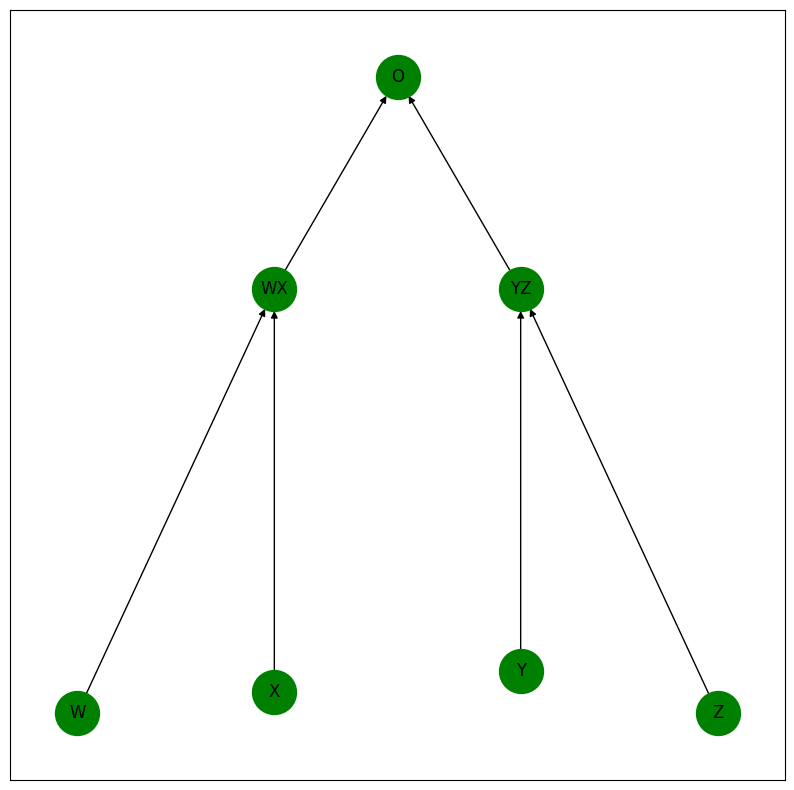

Timesteps: {'W': 0, 'X': 0, 'Y': 0, 'Z': 0, 'WX': 1, 'YZ': 1, 'O': 2}


In [110]:
equality_model.print_structure()
print("Timesteps:", equality_model.timesteps)

### The algorithm with no intervention

Let's first observe the behavior of the algorithm when we provide an input of the form `BBCD` with no interventions. Here is a visual depiction:

No intervention:
 defaultdict(None, {'W': array([-0.58, -0.38]), 'X': array([-0.58, -0.38]), 'Y': array([-0.3 ,  0.05]), 'Z': array([0.77, 0.52]), 'WX': True, 'YZ': False, 'O': False}) 



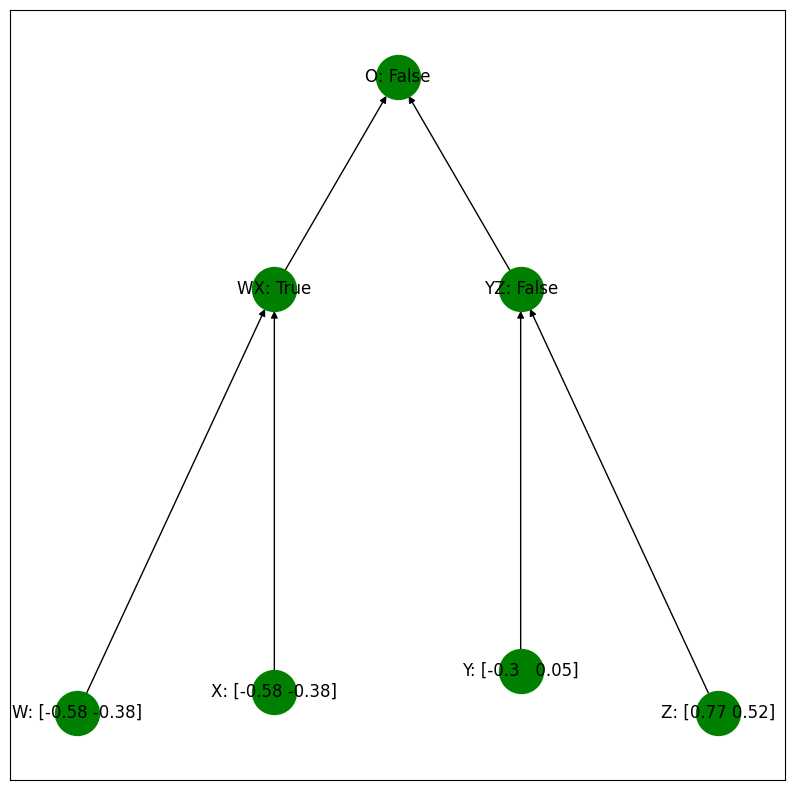

In [111]:
setting = equality_model.run_forward({"W": reps[0], "X": reps[0], "Y": reps[1], "Z": reps[3]})

print("No intervention:\n", setting, "\n")
equality_model.print_setting(setting)

### The algorithm with an intervention

Let's now see the behavior of the algorithm when we provide the input with an intervention setting **WX** to **False**. First, a visual depiction:

And then the same computation with `compute_A`:

Intervention setting WX to FALSE:



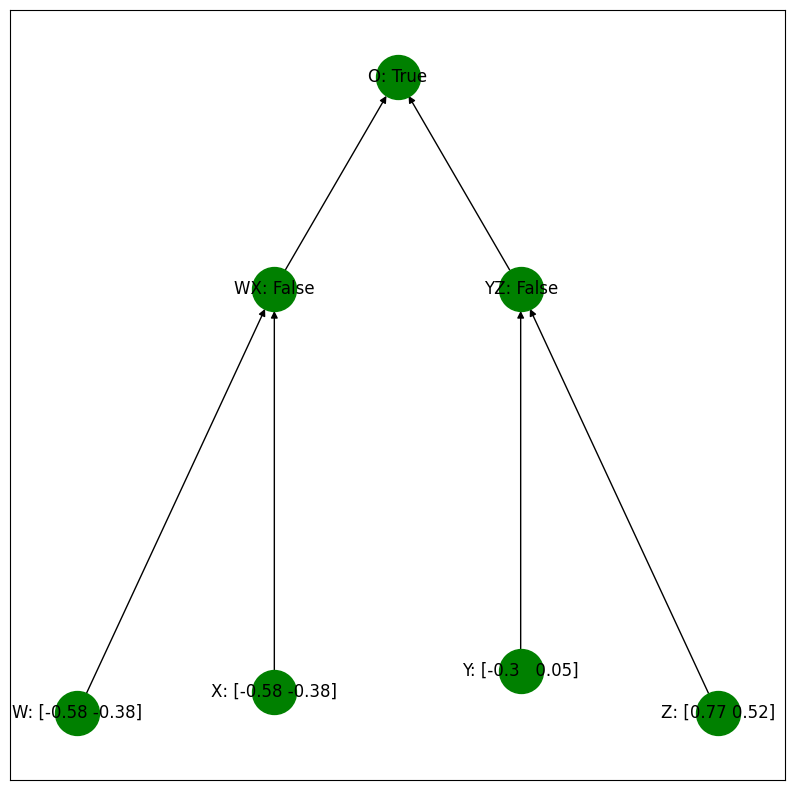

In [112]:
print("Intervention setting WX to FALSE:\n",)

equality_model.print_setting(equality_model.run_forward({"W": reps[0], "X": reps[0], "Y": reps[1], "Z": reps[3], "WX": False})
)

Notice that, in this example, even though the left two inputs are the same, the intervention has changed the intermediate prediction for those two inputs from **True** to **False**, and thus the algorithm outputs **True**, since **WX** and **YZ** are both **False**.

### The algorithm with an interchange intervention

Finally, let's observe the behavior of the algorithm when we provide the base input `BBCD` with an intervention setting **WX** to be the value it would be for the source input `ABCC`.

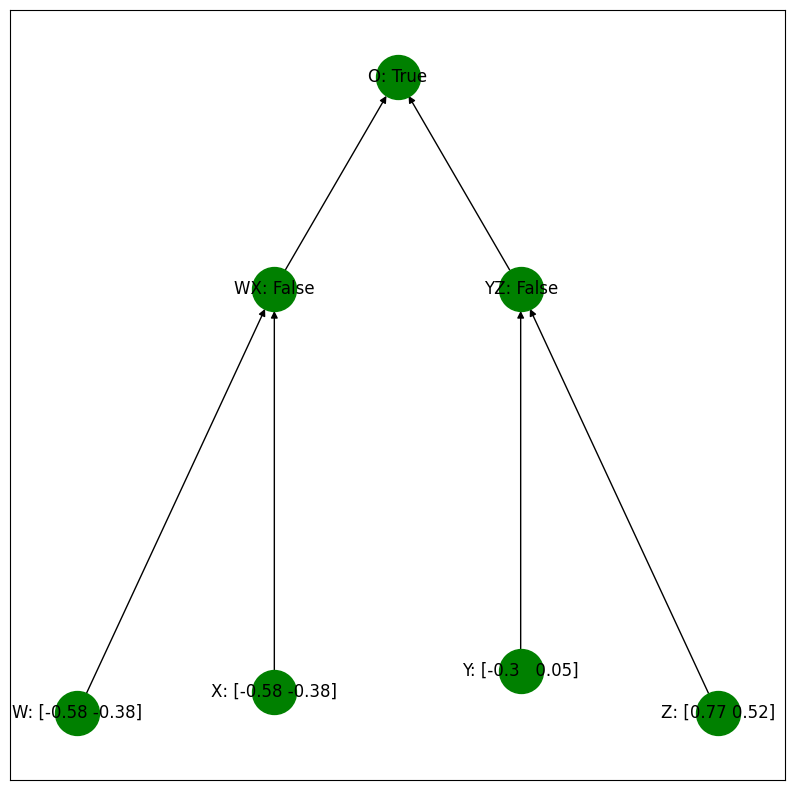

In [113]:
base = {"W": reps[0], "X": reps[0], "Y": reps[1], "Z": reps[3]}
source = {"W": reps[0], "X": reps[1], "Y": reps[2], "Z": reps[2]}
setting = equality_model.run_interchange(base, {"WX": source})
equality_model.print_setting(setting)

# Hand Crafting an MLP to Solve Hierarchical Equality

Before we train a network to solve the hierarchical equality task, first consider an analytical solution where we define a neural network to have weights that are handcrafted to solve the task by implementing the algorithm $\mathcal{A}$. The network is a two layer feedforward neural network that uses the ReLU function to compute the absolute difference between two vectors. 

In [114]:
config = MLPConfig(
    h_dim=embedding_dim * 4,
    activation_function="relu",
    n_layer=2,
    num_classes=2,
    pdrop=0.0,
)

In [115]:
config, tokenizer, handcrafted = create_mlp_classifier(config)

loaded model


The first layer of our handcrafted model computes:

$ReLU(W_1[\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d}]) = [max(\mathbf{a}-\mathbf{b}, 0), max(\mathbf{b}-\mathbf{a}, 0), max(\mathbf{c}-\mathbf{d}, 0), max(\mathbf{d}-\mathbf{c}, 0)]$


In [116]:
W1 = [
    [1, 0, -1, 0, 0, 0, 0, 0],
    [0, 1, 0, -1, 0, 0, 0, 0],
    [-1, 0, 1, 0, 0, 0, 0, 0],
    [0, -1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, -1, 0],
    [0, 0, 0, 0, 0, 1, 0, -1],
    [0, 0, 0, 0, -1, 0, 1, 0],
    [0, 0, 0, 0, 0, -1, 0, 1],
]
handcrafted.mlp.h[0].ff1.weight = torch.nn.Parameter(torch.FloatTensor(W1))
handcrafted.mlp.h[0].ff1.bias = torch.nn.Parameter(torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0]))

The second layer of our handcrafted model computes:

$ReLU(W_2ReLU(W_1[\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d}])) = [|\mathbf{a}-\mathbf{b}| - |\mathbf{c}-\mathbf{d}|, |\mathbf{c}-\mathbf{d}|-|\mathbf{a}-\mathbf{b}|, |\mathbf{a}-\mathbf{b}|, |\mathbf{c}-\mathbf{d}|,0,0,0,0]$


In [117]:
W2 = [
    [1, -1, 0, 1, 0, 0, 0, 0],
    [1, -1, 0, 1, 0, 0, 0, 0],
    [1, -1, 0, 1, 0, 0, 0, 0],
    [1, -1, 0, 1, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0, 0, 0],
    [-1, 1, 1, 0, 0, 0, 0, 0],
]
handcrafted.mlp.h[1].ff1.weight = torch.nn.Parameter(
    torch.FloatTensor(W2).transpose(0, 1)
)
handcrafted.mlp.h[1].ff1.bias = torch.nn.Parameter(
    torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0])
)

The third layer of our handcrafted model computes the logits:

$W_3 ReLU(W_2ReLU(W_1[\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d}])) = [||\mathbf{a}-\mathbf{b}| - |\mathbf{c}-\mathbf{d}|| -0.999999|\mathbf{a}-\mathbf{b}|-0.999999|\mathbf{c}-\mathbf{d}|, 0]$

In [118]:
W3 = [[1, 0], [1, 0], [-0.999999, 0], [-0.999999, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
handcrafted.score.weight = torch.nn.Parameter(torch.FloatTensor(W3).transpose(0, 1))
handcrafted.score.bias = torch.nn.Parameter(torch.FloatTensor([0, 0.00000000000001]))

**We can now use the causal model of $\mathcal{A}$ that we created to generate a labeled dataset for the hierarchical equality task** and show that our handcrafted network solves the task with perfect accuracy.

In [119]:
n_examples = 100000

examples = equality_model.generate_factual_dataset(n_examples, equality_model.sample_input_tree_balanced)

In [120]:
X = torch.stack([example['input_ids'] for example in examples])
y = torch.stack([example['labels'] for example in examples])

In [121]:
preds = handcrafted.forward(inputs_embeds=X)

print("Train Results")
print(classification_report(y, preds[0].argmax(1)))

Train Results
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     50114
         1.0       1.00      1.00      1.00     49886

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



# Causal abstraction

The theory of **causal abstraction** describes the conditions that must hold for the high-level tree structured algorithm to be a simplified and faithful description of the neural network. To perform causal abstraction analysis, we need to align high-level variables in our hypothesized algorithm $\mathcal{A}$ with sets of low-level variables in the low-level neural network $\mathcal{N}$. 

In essence: $\mathcal{A}$ is a causal abstraction of a $\mathcal{N}$ if and only if $\mathcal{A}$ and $\mathcal{N}$ provides the same output for all interchange interventions that target aligned variables.

For our handcrafted network, **we align the first four neurons in the first feed-forward layer with the high-level variable 'WX' and align the other four neurons in that layer with 'YZ'**. Below, we create an IntervenableConfig that allows us to taget the first four and last four neurons of the first layer for an interchange intervention. 

In [19]:
config = IntervenableConfig(
    model_type=type(handcrafted),
    representations=[
        RepresentationConfig(
            0,  # layer
            "block_output",  # component
            subspace_partition=[[0, 4], [4, 8]],
        ),
        RepresentationConfig(
            0,  # layer
            "block_output",  # component
            subspace_partition=[[0, 4], [4, 8]],
        ),
    ],
    intervention_types=VanillaIntervention,
)
handcrafted = IntervenableModel(config, handcrafted)

Next we create a counterfactual equality dataset that includes interchange intervention examples. We first define a function that creates an id for the three possible high-level interventions, namely targetting 'WX', targetting 'YZ', and targetting them both.

In [31]:
# map intervention variable to some id
def intervention_id(intervention):
    if "WX" in intervention and "YZ" in intervention:
        return 2
    if "WX" in intervention:
        return 0
    if "YZ" in intervention:
        return 1


data_size = 2048
batch_size = 16
# batch_size needed since dataset batched together in terms of intervention id
dataset = equality_model.generate_counterfactual_dataset(
    data_size,
    intervention_id,
    batch_size,
    device="cuda:0",
    sampler=equality_model.sample_input_tree_balanced,
)

This dataset has the following components:

* `input_ids`: a regular set of train examples
* `base_labels`: a regular set of train labels
* `source_input_ids`: sets additional training inputs sets **(here, two sets)** for interchange interventions
* `labels`: a list of labels if interchange interventions are performed with 'source_input_ids'
* `intervention_id`: a list of intervention sites (here, all `0` corresponding to our key for "V1")

In [59]:
print(dataset[0]["input_ids"])
print(dataset[0]["source_input_ids"])
print(dataset[0]["base_labels"])
print(dataset[0]["labels"])
print(dataset[0]["intervention_id"])

tensor([-0.9500, -0.6000, -0.9500, -0.6000, -0.5600,  0.1800, -0.5600,  0.1800],
       device='cuda:0')
tensor([[ 0.6100,  0.4000,  0.6100,  0.4000, -0.5600,  0.0100, -0.3200, -0.6900],
        [ 0.6200, -0.9900, -0.2400,  0.1000, -0.9500, -0.6000,  0.9100, -0.3300]],
       device='cuda:0')
tensor([1.], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([2], device='cuda:0')


To evaluate the model on this dataset, we loop through batches and peform interchange interventions based on the intervention_id. 
* When the id is 0, the first four neurons in the first layer are targetted ('WX' is targetted at the high-level)
* When the id is 1, the last four neurons in the first layer are targetted ('YZ' is targetted at the high-level)
* When the id is 2, all of the neurons in the first layer are targetted ('WX' and 'YZ' are both targetted at the high-level) 

In [63]:
for batch in DataLoader(dataset, batch_size):
    print(batch["source_input_ids"].shape)
    print(batch["source_input_ids"][:, 0].shape)
    break

torch.Size([16, 2, 8])
torch.Size([16, 8])


In [30]:
handcrafted.to("cuda:0")
for parameter in handcrafted.get_trainable_parameters():
    parameter.to("cuda:0")
preds = []

# VanillaIntervention
# Intervenable model forward :
# base,
# sources: Optional[List] = None, 
# unit_locations: Optional[Dict] = None,
# source_representations: Optional[Dict] = None,
# subspaces: Optional[List] = None,
# labels: Optional[torch.LongTensor] = None,
# output_original_output: Optional[bool] = False,
# return_dict: Optional[bool] = None,
# use_cache: Optional[bool] = True,

for batch in DataLoader(dataset, batch_size):
    batch["input_ids"] = batch["input_ids"].unsqueeze(1)
    batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)
    if batch["intervention_id"][0] == 2:  # Intervention on both high-level variables
        _, counterfactual_outputs = handcrafted(
            {"inputs_embeds": batch["input_ids"]},
            [
                {"inputs_embeds": batch["source_input_ids"][:, 0]},
                {"inputs_embeds": batch["source_input_ids"][:, 1]},
            ],
            {
                "sources->base": (
                    [[[0]] * batch_size, [[0]] * batch_size],
                    [[[0]] * batch_size, [[0]] * batch_size],
                )
            },
            subspaces=[[[0]] * batch_size, [[1]] * batch_size],
        )
    elif (
        batch["intervention_id"][0] == 0
    ):  # Intervention on just the high-level variable 'WX'
        _, counterfactual_outputs = handcrafted(
            {"inputs_embeds": batch["input_ids"]},  # base
            [{"inputs_embeds": batch["source_input_ids"][:, 0]}, None],  # sources
            {"sources->base": ([[[0]] * batch_size, None], [[[0]] * batch_size, None])},  # unit_locations
            subspaces=[[[0]] * batch_size, None],
        )
    elif (
        batch["intervention_id"][0] == 1
    ):  # Intervention on just the high-level variable 'YZ'
        _, counterfactual_outputs = handcrafted(
            {"inputs_embeds": batch["input_ids"]},
            [None, {"inputs_embeds": batch["source_input_ids"][:, 0]}],
            {"sources->base": ([None, [[0]] * batch_size], [None, [[0]] * batch_size])},
            subspaces=[None, [[1]] * batch_size],
        )
    preds.append(counterfactual_outputs[0])

In [45]:
len([[[0]] * batch_size, None][0])

16

In [31]:
preds = torch.cat(preds)

Below, we can see that our handcrafted neural network is a perfect implementation of the high-level algorithm.

In [32]:
print(
    classification_report(
        torch.tensor([x["labels"] for x in dataset]).cpu(), preds.argmax(1).cpu()
    )
)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       997
         1.0       1.00      1.00      1.00      1051

    accuracy                           1.00      2048
   macro avg       1.00      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048



# Training an MLP to Solve Hierarchical Equality

We've now seen how to perform causal abstraction analysis on a simple handcrafted neural networks. We turn now to training a neural network to perform the hierarchical equality task with a 4 dimensional vector embedding for each object. We define an input sampler to provide an infinite stream of new entities, rather than relying on a fixed set of vector representations.

In [33]:
embedding_dim = 4


def input_sampler():
    A = randvec(4)
    B = randvec(4)
    C = randvec(4)
    D = randvec(4)
    x = random.randint(1, 4)
    if x == 1:
        return {"W": A, "X": B, "Y": C, "Z": D}
    elif x == 2:
        return {"W": A, "X": A, "Y": B, "Z": B}
    elif x == 3:
        return {"W": A, "X": A, "Y": C, "Z": D}
    elif x == 4:
        return {"W": A, "X": B, "Y": C, "Z": C}

In [34]:
n_examples = 1048576
batch_size = 1024

examples = equality_model.generate_factual_dataset(n_examples, input_sampler)

X = torch.stack([example['input_ids'] for example in examples])
y = torch.stack([example['labels'] for example in examples])

# X = X.unsqueeze(1)

The examples in this dataset are 8-dimensional vectors: the concatenation of 4 2-dimensional vectors. Here's the first example with its label:

In [35]:
X[0], y[0]

(tensor([-0.7200,  0.6300,  1.0000,  0.6900, -0.7200,  0.6300,  1.0000,  0.6900,
          0.0800, -0.8800, -0.0400, -0.0400, -0.5200, -0.8500, -0.6400,  0.6400]),
 tensor([0.]))

The label for this example is determined by whether the equality value for the first two inputs matches the equality value for the second two inputs:

In [36]:
left = torch.equal(X[0][:embedding_dim], X[0][embedding_dim : embedding_dim * 2])

left

True

In [37]:
right = torch.equal(
    X[0][embedding_dim * 2 : embedding_dim * 3], X[0][embedding_dim * 3 :]
)

right

False

In [38]:
int(left == right)

0

We define a three layer neural network with a ReLU activation function this task:

In [39]:
config = MLPConfig(
    h_dim=embedding_dim * 4,
    activation_function="relu",
    n_layer=3,
    num_classes=2,
    pdrop=0.0,
)
config, tokenizer, trained = create_mlp_classifier(config)
trained.train()

loaded model


MLPForClassification(
  (mlp): MLPModel(
    (dropout): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-2): 3 x MLPBlock(
        (ff1): Linear(in_features=16, out_features=16, bias=True)
        (act): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (score): Linear(in_features=16, out_features=2, bias=True)
)

In [40]:
train_ds = Dataset.from_dict(
    {
        "labels": [
            torch.FloatTensor([0, 1]) if i == 1 else torch.FloatTensor([1, 0])
            for i in y
        ],
        "inputs_embeds": X,
    }
)

In [41]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    learning_rate=0.001,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none",
)

trainer = Trainer(
    model=trained,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=train_ds,
    compute_metrics=lambda x: {
        "accuracy": classification_report(
            x[0].argmax(1), x[1].argmax(1), output_dict=True
        )["accuracy"]
    },
)

This neural network achieves perfect performance on its train set:

In [42]:
_ = trainer.train()

  0%|          | 0/3072 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed
Checkpoint destination directory test_trainer\checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.6401, 'grad_norm': 0.23116283118724823, 'learning_rate': 0.0008372395833333334, 'epoch': 0.49}


Checkpoint destination directory test_trainer\checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.195, 'grad_norm': 0.18332688510417938, 'learning_rate': 0.0006744791666666667, 'epoch': 0.98}


  0%|          | 0/1024 [00:00<?, ?it/s]

{'eval_loss': 0.07157168537378311, 'eval_accuracy': 0.9790763854980469, 'eval_runtime': 37.061, 'eval_samples_per_second': 28293.236, 'eval_steps_per_second': 27.63, 'epoch': 1.0}


Checkpoint destination directory test_trainer\checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0472, 'grad_norm': 0.15438705682754517, 'learning_rate': 0.00051171875, 'epoch': 1.46}


Checkpoint destination directory test_trainer\checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.025, 'grad_norm': 0.1841142624616623, 'learning_rate': 0.00034895833333333334, 'epoch': 1.95}


  0%|          | 0/1024 [00:00<?, ?it/s]

{'eval_loss': 0.019501574337482452, 'eval_accuracy': 0.9946937561035156, 'eval_runtime': 37.7091, 'eval_samples_per_second': 27806.989, 'eval_steps_per_second': 27.155, 'epoch': 2.0}


Checkpoint destination directory test_trainer\checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0177, 'grad_norm': 0.18471458554267883, 'learning_rate': 0.00018619791666666665, 'epoch': 2.44}


Checkpoint destination directory test_trainer\checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'loss': 0.0149, 'grad_norm': 0.15878142416477203, 'learning_rate': 2.34375e-05, 'epoch': 2.93}


  0%|          | 0/1024 [00:00<?, ?it/s]

{'eval_loss': 0.014224954880774021, 'eval_accuracy': 0.9962148666381836, 'eval_runtime': 42.0755, 'eval_samples_per_second': 24921.316, 'eval_steps_per_second': 24.337, 'epoch': 3.0}
{'train_runtime': 257.663, 'train_samples_per_second': 12208.692, 'train_steps_per_second': 11.923, 'train_loss': 0.15329135081265122, 'epoch': 3.0}


Next we create a separate causal model with vector representations distinct from those used in training:

In [43]:
variables = ["W", "X", "Y", "Z", "WX", "YZ", "O"]

number_of_test_entities = 100

reps = [randvec(embedding_dim) for _ in range(number_of_test_entities)]
values = {variable: reps for variable in ["W", "X", "Y", "Z"]}
values["WX"] = [True, False]
values["YZ"] = [True, False]
values["O"] = [True, False]

parents = {
    "W": [],
    "X": [],
    "Y": [],
    "Z": [],
    "WX": ["W", "X"],
    "YZ": ["Y", "Z"],
    "O": ["WX", "YZ"],
}


def FILLER():
    return reps[0]


functions = {
    "W": FILLER,
    "X": FILLER,
    "Y": FILLER,
    "Z": FILLER,
    "WX": lambda x, y: np.array_equal(x, y),
    "YZ": lambda x, y: np.array_equal(x, y),
    "O": lambda x, y: x == y,
}

pos = {
    "W": (0, 0),
    "X": (1, 0.1),
    "Y": (2, 0.2),
    "Z": (3, 0),
    "WX": (1, 2),
    "YZ": (2, 2),
    "O": (1.5, 3),
}


test_equality_model = CausalModel(variables, values, parents, functions, pos=pos)

hi!


Our trained model generalizes perfectly this test set consisting of distinct vectors:

In [44]:
examples = test_equality_model.generate_factual_dataset(10000, input_sampler)
print("Test Results")

test_ds = Dataset.from_dict(
    {
        "labels": [
            torch.FloatTensor([0, 1]) if example['labels'].item() == 1 else torch.FloatTensor([1, 0])
            for example in examples
        ],
        "inputs_embeds": torch.stack([example['input_ids'] for example in examples]),
    }
)

test_preds = trainer.predict(test_ds)
y_test = [example['labels'].item() for example in examples]

print(classification_report(y_test, test_preds[0].argmax(1)))

Test Results


  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      5026
         1.0       1.00      0.99      1.00      4974

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



Does it implement our high-level model of the problem, though?

# Distributed Alignment Search



We previously handcrafted the weights of a network so the two high-level variables are perfectly stored in two non-overlapping sets of neurons in the first layer of the network. However, the trained network won't have axis aligned representations of high-level concepts. Rather, the two high-level variables will be encoded in multidimensional linear subspaces of the first layer in the network.  

To learn these subspaces, we define an IntervenableConfig that allows us to target the first layer of in the network after it has been rotated by an orthogonal matrix:

In [45]:
config = IntervenableConfig(
    model_type=type(trained),
    representations=[
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention type
            "pos",  # intervention unit is now aligne with tokens
            1,  # max number of unit
            subspace_partition=None,  # binary partition with equal sizes
            intervention_link_key=0,
        ),
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention type
            "pos",  # intervention unit is now aligne with tokens
            1,  # max number of unit
            subspace_partition=None,  # binary partition with equal sizes,
            intervention_link_key=0,
        ),
    ],
    intervention_types=RotatedSpaceIntervention,
)

In [46]:
intervenable = IntervenableModel(config, trained, use_fast=True)
intervenable.set_device("cuda")
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


In [47]:
epochs = 10
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(dataset) * epochs

t_total = int(len(dataset) * epochs)
optimizer_params = []
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=0.001)


def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        total_count += 1
        correct_count += eval_pred == eval_label
    accuracy = float(correct_count) / float(total_count)
    return {"accuracy": accuracy}


def compute_loss(outputs, labels):
    CE = torch.nn.CrossEntropyLoss()
    return CE(outputs, labels)


def batched_random_sampler(data):
    batch_indices = [_ for _ in range(int(len(data) / batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i * batch_size, (b_i + 1) * batch_size):
            yield i

In [68]:
def input_sampler(*args, **kwargs):
    A = randvec(4)
    B = randvec(4)
    C = randvec(4)
    D = randvec(4)
    if kwargs.get('output_var', None) is None:
        return random.choice([
            {"W": A, "X": B, "Y": C, "Z": D},
            {"W": A, "X": A, "Y": B, "Z": B},
            {"W": A, "X": A, "Y": C, "Z": D},
            {"W": A, "X": B, "Y": C, "Z": C}
        ])
    elif kwargs['output_var'] == 'WX' and kwargs['output_var_value']:
        return random.choice([
            {"W": A, "X": A, "Y": C, "Z": D},
            {"W": A, "X": A, "Y": C, "Z": C}
        ])
    elif kwargs['output_var'] == 'WX' and not kwargs['output_var_value']:
        return random.choice([
            {"W": A, "X": B, "Y": C, "Z": D},
            {"W": A, "X": B, "Y": C, "Z": C}
        ])
    elif kwargs['output_var'] == 'YZ' and kwargs['output_var_value']:
        return random.choice([
            {"W": A, "X": B, "Y": C, "Z": C},
            {"W": A, "X": A, "Y": C, "Z": C}
        ])
    else:
        return random.choice([
            {"W": A, "X": B, "Y": C, "Z": D},
            {"W": A, "X": A, "Y": C, "Z": D}
        ])

We again generate a counterfactual dataset using our high-level causal model:

In [69]:
n_examples = 1280000
batch_size = 6400
train_dataset = equality_model.generate_counterfactual_dataset(
    n_examples, intervention_id, batch_size, sampler=input_sampler
)

Then we train the orthgonal matrix to be such that the first four dimensions in the rotated space encode the high-level variable 'WX' and the second four dimensions encode the high-level variable 'YZ'. 

Again, we check the intervention_id for each batch of training data in order to determine whether to intervene of the first four rotated dimensions ('WX' is targetted at the high-level), the last four rotated dimensions ('YZ' is targetted at the high-level), or all of the dimensions ('WX' and 'YZ' are both targetted at the high-level). 

We can train the rotation matrix such that we get perfect interchange intervention accuracy, meaning the trained network perfectly implements the high-level algorithm on the training data.

In [80]:
intervenable.model.train()  # train enables drop-off but no grads
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

for epoch in train_iterator:
    epoch_iterator = tqdm(
        DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=batched_random_sampler(train_dataset),
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True,
    )
    for batch in epoch_iterator:
        batch["input_ids"] = batch["input_ids"].unsqueeze(1)
        batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)
        batch_size = batch["input_ids"].shape[0]
        for k, v in batch.items():
            if v is not None and isinstance(v, torch.Tensor):
                batch[k] = v.to("cuda")

        if batch["intervention_id"][0] == 2:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [
                    {"inputs_embeds": batch["source_input_ids"][:, 0]},
                    {"inputs_embeds": batch["source_input_ids"][:, 1]},
                ],
                {
                    "sources->base": (
                        [[[0]] * batch_size, [[0]] * batch_size],
                        [[[0]] * batch_size, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        elif batch["intervention_id"][0] == 0:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [{"inputs_embeds": batch["source_input_ids"][:, 0]}, None],
                {
                    "sources->base": (
                        [[[0]] * batch_size, None],
                        [[[0]] * batch_size, None],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    None,
                ],
            )
        elif batch["intervention_id"][0] == 1:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [None, {"inputs_embeds": batch["source_input_ids"][:, 0]}],
                {
                    "sources->base": (
                        [None, [[0]] * batch_size],
                        [None, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    None,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        eval_metrics = compute_metrics(
            counterfactual_outputs[0].argmax(1), batch["labels"].squeeze()
        )

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs[0], batch["labels"].squeeze().to(torch.long)
        )

        epoch_iterator.set_postfix({"loss": loss, "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()
        total_step += 1

intervention trainable parameters:  256


Epoch: 0: 0it [00:00, ?it/s] [00:00<?, ?it/s]

Epoch: 0: 200it [01:17,  2.59it/s, loss=tensor(0.4580, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.872]
Epoch: 1: 200it [00:54,  3.69it/s, loss=tensor(0.4646, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.89] 
Epoch: 2: 200it [00:53,  3.71it/s, loss=tensor(0.1925, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.962]
Epoch: 3: 200it [00:53,  3.71it/s, loss=tensor(0.5047, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.837]
Epoch: 4: 200it [00:54,  3.70it/s, loss=tensor(0.1448, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.969]
Epoch: 5: 200it [00:52,  3.81it/s, loss=tensor(0.1444, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.967]
Epoch: 6: 200it [00:58,  3.40it/s, loss=tensor(0.1562, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.97] 
Epoch: 7: 200it [01:04,  3.09it/s, loss=tensor(0.1703, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.958]
Epoch: 8: 200it [01:05,  3.07it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<NllLossBackward0>), acc

What's more, is it generalizes unseen test data:

In [81]:
test_dataset = test_equality_model.generate_counterfactual_dataset(
    10000, intervention_id, batch_size, device="cuda:0", sampler=input_sampler
)

In [82]:
eval_labels = []
eval_preds = []
with torch.no_grad():
    epoch_iterator = tqdm(DataLoader(test_dataset, batch_size), desc=f"Test")
    for step, batch in enumerate(epoch_iterator):
        for k, v in batch.items():
            if v is not None and isinstance(v, torch.Tensor):
                batch[k] = v.to("cuda")
        batch["input_ids"] = batch["input_ids"].unsqueeze(1)
        batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)
        if batch["intervention_id"][0] == 2:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [
                    {"inputs_embeds": batch["source_input_ids"][:, 0]},
                    {"inputs_embeds": batch["source_input_ids"][:, 1]},
                ],
                {
                    "sources->base": (
                        [[[0]] * batch_size, [[0]] * batch_size],
                        [[[0]] * batch_size, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        elif batch["intervention_id"][0] == 0:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [{"inputs_embeds": batch["source_input_ids"][:, 0]}, None],
                {
                    "sources->base": (
                        [[[0]] * batch_size, None],
                        [[[0]] * batch_size, None],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    None,
                ],
            )
        elif batch["intervention_id"][0] == 1:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [None, {"inputs_embeds": batch["source_input_ids"][:, 0]}],
                {
                    "sources->base": (
                        [None, [[0]] * batch_size],
                        [None, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    None,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        eval_labels += [batch["labels"]]
        eval_preds += [torch.argmax(counterfactual_outputs[0], dim=1)]
print(classification_report(torch.cat(eval_labels).cpu(), torch.cat(eval_preds).cpu()))

Test:   0%|          | 0/2 [00:00<?, ?it/s]

Test: 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      6407
         1.0       0.96      0.98      0.97      6393

    accuracy                           0.97     12800
   macro avg       0.97      0.97      0.97     12800
weighted avg       0.97      0.97      0.97     12800

